In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/AudioProcessing/Emotion_Recognition'
%ls

/content/drive/My Drive/AudioProcessing/Emotion_Recognition
 CREMA/     kaggle.json            RAVDESS_copied/                     try/
 EMODB/     model.png              SAVEE/
 EMO_DB/   'Papers & Materials'@   speech-emotion-recognition-en.zip
 IEMOCAP/   RAVDESS/               TESS/


In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint, Callback
from sklearn.preprocessing import  StandardScaler
import sklearn
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
import tensorflow as tf
import csv
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from sklearn import feature_selection
import matplotlib.pyplot as plt

# DataSet Splitting

In [ ]:
def decompose_emodb():

        EMODB_PATH = 'EMO_DB/'
        emotion = []
        path = []
        for dirname, _, filenames in os.walk('EMO_DB/wav'):
          for name in filenames[1:]:
            #print(name,len(name))

                if name[0:2] in '0310111215':  # MALE
                    if name[5] == 'W':  # Ärger (Wut) -> Angry
                        emotion.append('m_angry')
                    elif name[5] == 'L':  # Langeweile -> Boredom
                        emotion.append('m_bored')
                    elif name[5] == 'E':  # Ekel -> Disgusted
                        emotion.append('m_disgust')
                    elif name[5] == 'A':  # Angst -> Fear
                        emotion.append('m_fear')
                    elif name[5] == 'F':  # Freude -> Happiness
                        emotion.append('m_happy')
                    elif name[5] == 'T':  # Trauer -> Sadness
                        emotion.append('m_sad')
                    else:
                        #print(name)
                        emotion.append('m_neutral')
                else:
                    if name[5] == 'W':  # Ärger (Wut) -> Angry
                        emotion.append('f_angry')
                    elif name[5] == 'L':  # Langeweile -> Boredom
                        emotion.append('f_bored')
                    elif name[5] == 'E':  # Ekel -> Disgusted
                        emotion.append('f_disgust')
                    elif name[5] == 'A':  # Angst -> Fear
                        emotion.append('f_fear')
                    elif name[5] == 'F':  # Freude -> Happiness
                        emotion.append('f_happy')
                    elif name[5] == 'T':  # Trauer -> Sadness
                        emotion.append('f_sad')
                    else:
                        emotion.append('f_neutral')

                path.append(os.path.join(EMODB_PATH+'wav', name))

        print(len(path),len(emotion))
        emodb_df = pd.DataFrame(emotion, columns=['labels'])
        #emodb_df['source'] = 'EMODB'
        emodb_df = pd.concat([emodb_df, pd.DataFrame(path, columns=['path'])], axis=1)
        
        return emodb_df

df = decompose_emodb()
print(df.shape)
df.to_csv('EMO_DB/EMODB_details.csv',index=False,index_label=False)

534 534
(534, 2)


In [ ]:
#angry, happy, neutral, sad
X = pd.read_csv('EMO_DB/EMODB_details.csv',usecols=['labels','path'])
options = ['m_angry', 'm_happy','m_neutral','m_sad',
           'f_angry', 'f_happy','f_neutral','f_sad'] 
  
rslt_df = X[X['labels'].isin(options)] 
print(np.unique(rslt_df.labels))
print(rslt_df.shape)
rslt_df.head()

test_val= rslt_df.sample(frac = 0.3)
train = rslt_df.drop(test_val.index)

test= test_val.sample(frac = 0.5)
val = test_val.drop(test.index)

print(val['labels'].unique())
print(test['labels'].unique())
print(train['labels'].unique())

['f_angry' 'f_happy' 'f_neutral' 'f_sad' 'm_angry' 'm_happy' 'm_neutral'
 'm_sad']
(338, 2)
['m_angry' 'f_neutral' 'f_happy' 'f_sad' 'f_angry' 'm_neutral' 'm_sad'
 'm_happy']
['f_angry' 'm_angry' 'f_sad' 'm_neutral' 'f_happy' 'f_neutral' 'm_sad'
 'm_happy']
['m_happy' 'm_angry' 'm_sad' 'm_neutral' 'f_happy' 'f_neutral' 'f_angry'
 'f_sad']


In [ ]:
train.to_csv("EMO_DB//train.csv")
test.to_csv("EMO_DB//test.csv")
val.to_csv("EMO_DB//val.csv")

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_EMODB_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_EMODB_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_EMODB_val.csv'
extract_features(csvpath,val_csv)

# Data Loading

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
csvpath = 'EMO_DB/hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB/hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 26) (237, 1)
(50, 26) (50, 1)
(51, 26) (51, 1)


# Feature Importance Comparison

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


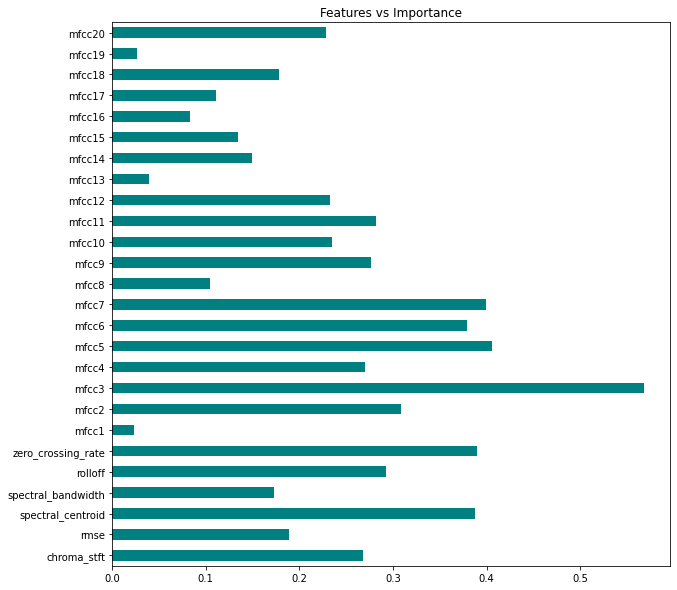

In [ ]:
importances = feature_selection.mutual_info_classif(X_train_features,Y_train_features)
feat_importances = pd.Series(importances,data.columns[0:len(data.columns)-1])
plt.figure(figsize = (10,10))
feat_importances.plot(kind = 'barh',color = 'teal')
plt.title("Features vs Importance")
plt.show()

# WaveNet Paper

In [ ]:
# hyper-parameters
n_filters = 32
filter_width = 2
dilation_rates = [2**i for i in range(4)] * 2 
sr = 16000
# define an input history series and pass it through a stack of dilated causal convolution blocks
history_seq = Input(shape=(int(sr*time), 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))
out = AveragePooling1D(sr*time)(out)
out = Conv1D(8,1,activation='relu')(out)
out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet_paper = Model(history_seq, out)
Wavenet_paper.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_298 (Conv1D)             (None, 64000, 16)    32          input_16[0][0]                   
__________________________________________________________________________________________________
conv1d_299 (Conv1D)             (None, 64000, 32)    1056        conv1d_298[0][0]                 
__________________________________________________________________________________________________
conv1d_300 (Conv1D)             (None, 64000, 32)    1056        conv1d_298[0][0]                 
___________________________________________________________________________________________

In [ ]:
Wavenet_paper.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//wavenet_paper_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//wavenet_paper_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet_paper.fit(X_train,Y_train, batch_size=20,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
12/12 [==============================] - 23s 2s/step - loss: 1.3864 - accuracy: 0.7500 - val_loss: 1.3861 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.38608, saving model to EMO_DB//models/wavenet_paper_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to EMO_DB//models/wavenet_paper_acc.h5
Epoch 2/30
12/12 [==============================] - 19s 2s/step - loss: 1.3816 - accuracy: 0.7500 - val_loss: 1.3859 - val_accuracy: 0.7500

Epoch 00002: val_loss improved from 1.38608 to 1.38588, saving model to EMO_DB//models/wavenet_paper_loss.h5

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/30
12/12 [==============================] - 19s 2s/step - loss: 1.3756 - accuracy: 0.7500 - val_loss: 1.3859 - val_accuracy: 0.7500

Epoch 00003: val_loss improved from 1.38588 to 1.38585, saving model to EMO_DB//models/wavenet_paper_loss.h5

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/30
12/12 [==============

In [ ]:
Wavenet_paper.evaluate(X_test,Y_test)
Wavenet_paper.load_weights('EMO_DB//models//wavenet_paper_loss.h5')
print(Wavenet_paper.evaluate(X_test,Y_test))
Wavenet_paper.load_weights('EMO_DB//models//wavenet_paper_acc.h5')
Wavenet_paper.evaluate(X_test,Y_test)

2/2 [==============================] - 1s 562ms/step - loss: 0.6061 - accuracy: 0.8550
[0.6060598492622375, 0.8550000190734863]
2/2 [==============================] - 1s 560ms/step - loss: 0.6061 - accuracy: 0.8550


[0.6060598492622375, 0.8550000190734863]

2/2 [==============================] - 2s 576ms/step - loss: 0.6061 - accuracy: 0.8550
(50,) (50,)
F1 SCORE: 0.5922943722943723
Kappa: 0.6370235934664248
Accuracy: 0.76
Jaccard Score: 0.49313186813186816
Precision: 0.5600649350649352
Recall: 0.6318181818181818


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


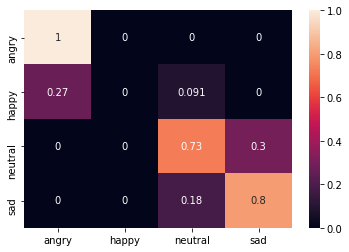

In [ ]:
Wavenet_paper.load_weights('EMO_DB//models//wavenet_paper_loss.h5')

Wavenet_paper.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet_paper.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Wavenet 5

In [ ]:
# hyper-parameters

def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention

n_filters = 64
filter_width = 2
dilation_rates = [2**i for i in range(3)]  
sr = 16000

history_seq = Input(shape=(int(sr*4), 1))
x = history_seq


x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)

x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
x = AveragePooling1D()(x)
skips = []
for dilation_rate in dilation_rates:
    
    
    x = Conv1D(32, 1, padding='same', activation='relu')(x) 
    
    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(32, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    
    skips.append(z)


out = Activation('relu')(Add()(skips))

out = AveragePooling1D(8000)(out)
out = self_attention(out)

out = Conv1D(4,1,activation='softmax')(out)
out = Reshape((4,1))(out)

Wavenet5 = Model(history_seq, out)
Wavenet5.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_332 (Conv1D)             (None, 64000, 8)     48          input_17[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_44 (LeakyReLU)      (None, 64000, 8)     0           conv1d_332[0][0]                 
__________________________________________________________________________________________________
conv1d_333 (Conv1D)             (None, 64000, 8)     328         leaky_re_lu_44[0][0]             
___________________________________________________________________________________________

In [ ]:
Wavenet5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//wavenet5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//wavenet5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = Wavenet5.fit(X_train,
                        Y_train, 
                        batch_size=16,
                        validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - 7s 311ms/step - loss: 1.3776 - accuracy: 0.7500 - val_loss: 1.4199 - val_accuracy: 0.7500

Epoch 00001: val_loss improved from inf to 1.41988, saving model to EMO_DB//models/wavenet5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.75000, saving model to EMO_DB//models/wavenet5_acc.h5
Epoch 2/30
15/15 [==============================] - 3s 222ms/step - loss: 1.3431 - accuracy: 0.7500 - val_loss: 1.4517 - val_accuracy: 0.7500

Epoch 00002: val_loss did not improve from 1.41988

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/30
15/15 [==============================] - 3s 223ms/step - loss: 1.3652 - accuracy: 0.7500 - val_loss: 1.4565 - val_accuracy: 0.7500

Epoch 00003: val_loss did not improve from 1.41988

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/30
15/15 [==============================] - 3s 224ms/step - loss: 1.3206 - accuracy: 0.7500 - val_loss: 1.4235 - val_accuracy: 0.7549

Epoch 000

In [ ]:
Wavenet5.load_weights('EMO_DB//models//wavenet5_loss.h5')
print(Wavenet5.evaluate(X_test,Y_test))
Wavenet5.load_weights('EMO_DB//models//wavenet5_acc.h5')
Wavenet5.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 124ms/step - loss: 0.4743 - accuracy: 0.9100
[0.4743371307849884, 0.9100000262260437]
2/2 [==============================] - 0s 111ms/step - loss: 0.4743 - accuracy: 0.9100


[0.4743371307849884, 0.9100000262260437]

2/2 [==============================] - 0s 129ms/step - loss: 0.4743 - accuracy: 0.9100
(50,) (50,)
F1 SCORE: 0.7710227272727272
Kappa: 0.7630331753554502
Accuracy: 0.84
Jaccard Score: 0.6698232323232324
Precision: 0.826923076923077
Recall: 0.7646103896103896


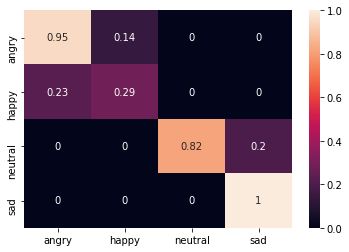

In [ ]:
Wavenet5.load_weights('EMO_DB//models//wavenet5_acc.h5')

Wavenet5.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(Wavenet5.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(Wavenet5.predict(X_test).reshape(Y_test_features.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# ANN

In [ ]:
from keras.models import *
from keras.layers import *
ann_model = Sequential(name='Input_Layer')
ann_model.add(Dense(128,name='Dense_1'))
ann_model.add(LeakyReLU(name='Leaky_Relu_Activation_1'))
ann_model.add(Dense(32,name='Dense_2'))
ann_model.add(LeakyReLU(name = 'LEaky_Relu_Activation_2'))
ann_model.add(Dense(4, activation='softmax',name='Output_Layer'))

ann_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
ann_model.build((1,26))
ann_model.summary()


Model: "Input_Layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (1, 128)                  3456      
_________________________________________________________________
Leaky_Relu_Activation_1 (Lea (1, 128)                  0         
_________________________________________________________________
Dense_2 (Dense)              (1, 32)                   4128      
_________________________________________________________________
LEaky_Relu_Activation_2 (Lea (1, 32)                   0         
_________________________________________________________________
Output_Layer (Dense)         (1, 4)                    132       
Total params: 7,716
Trainable params: 7,716
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann_model = Sequential(name='Input_Layer')
ann_model.add(Dense(256,name='Dense_1'))
ann_model.add(LeakyReLU(name='Leaky_Relu_Activation_1'))
ann_model.add(Dense(64,name='Dense_2'))
ann_model.add(LeakyReLU(name = 'LEaky_Relu_Activation_2'))
ann_model.add(Dense(4, activation='softmax',name='Output_Layer'))

ann_model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ANN1.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ANN2.h5', monitor='val_accuracy',verbose=1, save_best_only=True)

ann_model.fit(X_train_features,
          Y_train_features,
          epochs=30,
          batch_size=20,
          validation_data=(X_val_features, Y_val_features),callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
12/12 [==============================] - 1s 19ms/step - loss: 1.2072 - accuracy: 0.4333 - val_loss: 0.7218 - val_accuracy: 0.7451

Epoch 00001: val_loss improved from inf to 0.72180, saving model to EMO_DB//models/ANN1.h5

Epoch 00001: val_accuracy improved from -inf to 0.74510, saving model to EMO_DB//models/ANN2.h5
Epoch 2/30
12/12 [==============================] - 0s 6ms/step - loss: 0.5692 - accuracy: 0.8016 - val_loss: 0.5279 - val_accuracy: 0.7843

Epoch 00002: val_loss improved from 0.72180 to 0.52793, saving model to EMO_DB//models/ANN1.h5

Epoch 00002: val_accuracy improved from 0.74510 to 0.78431, saving model to EMO_DB//models/ANN2.h5
Epoch 3/30
12/12 [==============================] - 0s 6ms/step - loss: 0.4065 - accuracy: 0.8522 - val_loss: 0.4869 - val_accuracy: 0.7647

Epoch 00003: val_loss improved from 0.52793 to 0.48692, saving model to EMO_DB//models/ANN1.h5

Epoch 00003: val_accuracy did not improve from 0.78431
Epoch 4/30
12/12 [========================

In [ ]:
ann_model.load_weights('EMO_DB//models//ANN2.h5')
print(ann_model.evaluate(X_test_features,Y_test_features))
ann_model.load_weights('EMO_DB//models//ANN1.h5')
print(ann_model.evaluate(X_test_features,Y_test_features))


2/2 [==============================] - 0s 6ms/step - loss: 0.1766 - accuracy: 0.9400
[0.176630899310112, 0.9399999976158142]
2/2 [==============================] - 0s 7ms/step - loss: 0.1988 - accuracy: 0.9400
[0.19882060587406158, 0.9399999976158142]


2/2 [==============================] - 0s 8ms/step - loss: 0.1988 - accuracy: 0.9400
[0.19882060587406158, 0.9399999976158142]
F1 SCORE: 0.9289082687338501
Kappa: 0.9147242751563388
Accuracy: 0.94
Jaccard Score: 0.8689248251748252
Precision: 0.9302884615384616
Recall: 0.9386363636363637


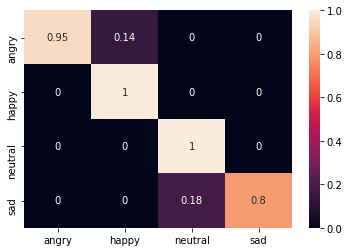

In [ ]:
ann_model.load_weights('EMO_DB//models//ANN1.h5')
print(ann_model.evaluate(X_test_features,Y_test_features))
g = Y_test_features
p = np.argmax(ann_model.predict(X_test_features),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(Y_test_features,np.argmax(ann_model.predict(X_test_features),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Ensembled

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*4), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_354 (Conv1D)             (None, 64000, 8)     48          input_18[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_50 (LeakyReLU)      (None, 64000, 8)     0           conv1d_354[0][0]                 
__________________________________________________________________________________________________
conv1d_355 (Conv1D)             (None, 64000, 8)     328         leaky_re_lu_50[0][0]             
___________________________________________________________________________________________

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - 7s 269ms/step - loss: 1.2436 - accuracy: 0.4890 - val_loss: 1.0460 - val_accuracy: 0.6078

Epoch 00001: val_loss improved from inf to 1.04598, saving model to EMO_DB//models/ensembled_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.60784, saving model to EMO_DB//models/ensembled_acc.h5
Epoch 2/30
15/15 [==============================] - 3s 225ms/step - loss: 0.8565 - accuracy: 0.7453 - val_loss: 0.8105 - val_accuracy: 0.7647

Epoch 00002: val_loss improved from 1.04598 to 0.81046, saving model to EMO_DB//models/ensembled_loss.h5

Epoch 00002: val_accuracy improved from 0.60784 to 0.76471, saving model to EMO_DB//models/ensembled_acc.h5
Epoch 3/30
15/15 [==============================] - 3s 222ms/step - loss: 0.6613 - accuracy: 0.8290 - val_loss: 0.6720 - val_accuracy: 0.7843

Epoch 00003: val_loss improved from 0.81046 to 0.67199, saving model to EMO_DB//models/ensembled_loss.h5

Epoch 00003: val_accuracy improved from 0.76

In [ ]:
print(ensembled.evaluate([X_test,X_test_features],Y_test))
ensembled.load_weights("EMO_DB//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("EMO_DB//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 0s 124ms/step - loss: 0.1214 - accuracy: 0.9400
[0.12144515663385391, 0.9399999976158142]
2/2 [==============================] - 0s 103ms/step - loss: 0.1313 - accuracy: 0.9800
[0.13132430613040924, 0.9800000190734863]
2/2 [==============================] - 0s 103ms/step - loss: 0.2011 - accuracy: 0.9400


[0.2010892629623413, 0.9399999976158142]

In [ ]:
print(ensembled.evaluate([X_test,X_test_features],Y_test))
ensembled.load_weights("EMO_DB//models/ensembled2_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("EMO_DB//models/ensembled2_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 0s 123ms/step - loss: 0.1241 - accuracy: 0.9600
[0.1241101324558258, 0.9599999785423279]
2/2 [==============================] - 0s 112ms/step - loss: 0.1483 - accuracy: 0.9400
[0.14827194809913635, 0.9399999976158142]
2/2 [==============================] - 0s 103ms/step - loss: 0.1437 - accuracy: 0.9600


[0.14370474219322205, 0.9599999785423279]

2/2 [==============================] - 0s 126ms/step - loss: 0.1313 - accuracy: 0.9800
[0.13132430613040924, 0.9800000190734863]
F1 SCORE: 0.9775193798449613
Kappa: 0.9716070414537195
Accuracy: 0.98
Jaccard Score: 0.9573863636363636
Precision: 0.96875
Recall: 0.9886363636363636


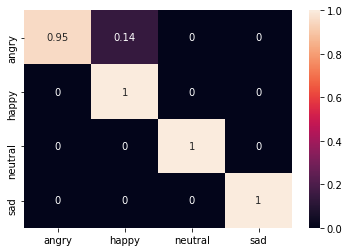

In [ ]:
ensembled.load_weights("EMO_DB//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Ensembled New

In [ ]:
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)


  out = Conv1D(4,1,activation='softmax')(out)
  out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  out2 = Dense(4,activation = 'softmax')(layer3)
  out2 = Reshape((4,1))(out2)

  output_layer = Average()([out1,out2])
  
  
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_new = Wavenet()
ensembled_new.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 64000, 8)     48          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64000, 8)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 64000, 8)     328         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [ ]:
ensembled_new.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//ensembled_new_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//ensembled_new_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_new.fit([X_train,X_train_features],Y_train, batch_size=16,validation_data=([X_val,X_val_features], Y_val),epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - 38s 192ms/step - loss: 1.2285 - accuracy: 0.7581 - val_loss: 0.9657 - val_accuracy: 0.7941

Epoch 00001: val_loss improved from inf to 0.96566, saving model to EMODB//models/ensembled_new_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.79412, saving model to EMODB//models/ensembled_new_acc.h5
Epoch 2/30
15/15 [==============================] - 2s 104ms/step - loss: 0.8673 - accuracy: 0.8377 - val_loss: 0.8556 - val_accuracy: 0.8039

Epoch 00002: val_loss improved from 0.96566 to 0.85564, saving model to EMODB//models/ensembled_new_loss.h5

Epoch 00002: val_accuracy improved from 0.79412 to 0.80392, saving model to EMODB//models/ensembled_new_acc.h5
Epoch 3/30
15/15 [==============================] - 2s 103ms/step - loss: 0.7884 - accuracy: 0.8556 - val_loss: 0.8186 - val_accuracy: 0.8186

Epoch 00003: val_loss improved from 0.85564 to 0.81856, saving model to EMODB//models/ensembled_new_loss.h5

Epoch 00003: val_accuracy im

In [ ]:

ensembled_new.load_weights("EMODB//models/ensembled_new_loss.h5")
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))

ensembled_new.load_weights("EMODB//models/ensembled_new_acc.h5")
ensembled_new.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 199ms/step - loss: 0.3105 - accuracy: 0.9650
[0.31053170561790466, 0.9649999737739563]
2/2 [==============================] - 0s 45ms/step - loss: 0.3168 - accuracy: 0.9800


[0.31680232286453247, 0.9800000190734863]

2/2 [==============================] - 0s 59ms/step - loss: 0.3168 - accuracy: 0.9800
[0.31680232286453247, 0.9800000190734863]
F1 SCORE: 0.9511862152594419
Kappa: 0.9421965317919075
Accuracy: 0.96
Jaccard Score: 0.9075828157349896
Precision: 0.9682971014492754
Recall: 0.9392857142857143


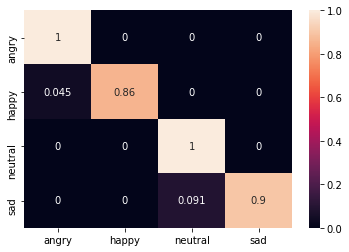

In [ ]:
#test set
print(ensembled_new.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_new.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


# Spectogram

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename)
          
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
      spect = librosa.power_to_db(spect, ref=np.max)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('EMO_DB/EMODB_details.csv',usecols=['labels','path'])
options = ['m_angry', 'm_happy','m_neutral','m_sad',
           'f_angry', 'f_happy','f_neutral','f_sad']

time = 4
rslt_df = X[X['labels'].isin(options)]


audio_files=[]
labels=[]

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot

max_x,max_y = findmaxsize(rslt_df)



The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (128, 194)


In [ ]:
def extract_mel_spectrogram(df,max_x,max_y):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
      spect = librosa.power_to_db(spect, ref=np.max)
 
            # Adjusting the size to be 128 x 660
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
 
      mel_specs.append(spect)
      labels.append(label_to_onehot(row['labels']))
  mel_specs = np.array(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv,max_x,max_y)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
X_train_spec = np.expand_dims(X_train_spec,axis=3)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv,max_x,max_y)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
X_test_spec = np.expand_dims(X_test_spec,axis=3)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv,max_x,max_y)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
X_val_spec = np.expand_dims(X_val_spec,axis=3)
print(X_val_spec.shape,Y_val_spec.shape)

(237, 128, 194, 1) (237, 4)
(50, 128, 194, 1) (50, 4)
(51, 128, 194, 1) (51, 4)


In [ ]:
cnn_model = Sequential(name='Convolutional_Neural_Network')

cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     input_shape=(max_x,max_y,1),name = "Input_Convolution_Layer"))
cnn_model.add(LeakyReLU( name = "Leaky_Relu_Activation_1"))
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4),name = 'Max_Pooling_1'))

# Adding convolutional layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),name = "Convolution_Layer_2"
                     ))
cnn_model.add(LeakyReLU(name = "Leaky_Relu_Activation_2"))
# Adding max pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4),name = 'Max_Pooling_2'))

# Adding a flattened layer to input our image data
cnn_model.add(Flatten(name = 'Flatten'))

# Adding a dense layer with 64 neurons
cnn_model.add(Dense(64,name = 'Dense_1' ))
cnn_model.add(LeakyReLU())

# Adding a dropout layer for regularization
cnn_model.add(Dropout(0.25,name = 'Dropout'))

# Adding an output layer
cnn_model.add(Dense(4, activation='softmax',name = 'Output_Layer'))

# Compiling our neural network
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model_checkpoint = ModelCheckpoint(f'EMO_DB//models//CNN.h5', monitor='val_loss',verbose=1, save_best_only=True)
# Fitting our neural network
history = cnn_model.fit(X_train_spec,
                        Y_train_spec, 
                        batch_size=16,
                        validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = model_checkpoint)

Epoch 1/30
15/15 [==============================] - 1s 34ms/step - loss: 2.0511 - accuracy: 0.3598 - val_loss: 1.3086 - val_accuracy: 0.3529

Epoch 00001: val_loss improved from inf to 1.30856, saving model to EMO_DB//models/CNN.h5
Epoch 2/30
15/15 [==============================] - 0s 10ms/step - loss: 1.2433 - accuracy: 0.4095 - val_loss: 1.2119 - val_accuracy: 0.4510

Epoch 00002: val_loss improved from 1.30856 to 1.21185, saving model to EMO_DB//models/CNN.h5
Epoch 3/30
15/15 [==============================] - 0s 10ms/step - loss: 1.1012 - accuracy: 0.5287 - val_loss: 1.0892 - val_accuracy: 0.5490

Epoch 00003: val_loss improved from 1.21185 to 1.08919, saving model to EMO_DB//models/CNN.h5
Epoch 4/30
15/15 [==============================] - 0s 10ms/step - loss: 0.9723 - accuracy: 0.5945 - val_loss: 1.0110 - val_accuracy: 0.6078

Epoch 00004: val_loss improved from 1.08919 to 1.01102, saving model to EMO_DB//models/CNN.h5
Epoch 5/30
15/15 [==============================] - 0s 10ms/

In [ ]:
cnn_model.load_weights('EMO_DB//models//CNN.h5')
cnn_model.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 0s 76ms/step - loss: 0.3502 - accuracy: 0.8600


[0.3502076268196106, 0.8600000143051147]

F1 SCORE: 0.8167249417249417
Kappa: 0.7978047371461583
Accuracy: 0.86
Jaccard Score: 0.7074834887334888
Precision: 0.8244729907773386
Recall: 0.811038961038961


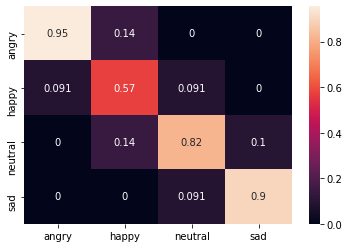

In [ ]:
#test set

g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(cnn_model.predict(X_test_spec),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(cnn_model.predict(X_test_spec),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Paper_1

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 8
srk = 44100
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = srk)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

In [ ]:
def paper_model():
  inp = Input((srk*time,1))
  l1 = BatchNormalization()(Conv1D(32,21,activation='relu',padding = 'same')(inp))
  m1 = MaxPool1D(2)(l1)

  l2 = BatchNormalization()(Conv1D(64,19,activation='relu',padding = 'same')(m1))
  m2 = MaxPool1D(2)(l2)

  l3 = BatchNormalization()(Conv1D(128,17,activation='relu',padding = 'same')(m2))
  m3 = MaxPool1D(2)(l3)


  l4 = BatchNormalization()(Conv1D(256,15,activation='relu',padding = 'same')(m3))
  m4 = MaxPool1D(2)(l4)

  l5 = BatchNormalization()(Conv1D(512,13,activation='relu',padding = 'same')(m4))
  m5 = MaxPool1D(2)(l5)

  l6 = BatchNormalization()(Conv1D(1024,11,activation='relu',padding = 'same')(m5))
  m6 = MaxPool1D(2)(l6)

  l7 = BatchNormalization()(Conv1D(1024,9,activation='relu',padding = 'same')(m6))
  m7 = GlobalMaxPool1D()(l7)

  fl = Flatten()(m7)
  d1 = Dense(128,activation='relu')(fl)
  out = Dense(4,activation='softmax')(d1)

  return Model(inputs = inp,outputs = out)

m = paper_model()
m.summary()

## Trial 1

In [ ]:
m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_1_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_1_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = m.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 154s 3s/step - loss: 13.2951 - accuracy: 0.3243 - val_loss: 4.5678 - val_accuracy: 0.1373

Epoch 00001: val_loss improved from inf to 4.56778, saving model to EMODB//models/paper_1_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.13725, saving model to EMODB//models/paper_1_acc.h5
Epoch 2/30
30/30 [==============================] - 92s 3s/step - loss: 1.9484 - accuracy: 0.4970 - val_loss: 5.5771 - val_accuracy: 0.2549

Epoch 00002: val_loss did not improve from 4.56778

Epoch 00002: val_accuracy improved from 0.13725 to 0.25490, saving model to EMODB//models/paper_1_acc.h5
Epoch 3/30
30/30 [==============================] - 94s 3s/step - loss: 1.5728 - accuracy: 0.5744 - val_loss: 4.8159 - val_accuracy: 0.2157

Epoch 00003: val_loss did not improve from 4.56778

Epoch 00003: val_accuracy did not improve from 0.25490
Epoch 4/30
30/30 [==============================] - 94s 3s/step - loss: 0.9815 - accuracy: 0.5950 - val_loss: 

In [ ]:
m.load_weights('EMODB//models//paper_1_acc.h5')
print(m.evaluate(X_test,Y_test))
m.load_weights('EMODB//models//paper_1_loss.h5')
m.evaluate(X_test,Y_test)

2/2 [==============================] - 29s 12s/step - loss: 0.4929 - accuracy: 0.8200
[0.4929375946521759, 0.8199999928474426]
2/2 [==============================] - 3s 1s/step - loss: 0.4995 - accuracy: 0.8200


[0.49954158067703247, 0.8199999928474426]

F1 SCORE: 0.7703089244851258
Kappa: 0.7382198952879581
Accuracy: 0.82
Jaccard Score: 0.6497668997668998
Precision: 0.8006410256410257
Recall: 0.7662337662337662
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        22
           1       0.60      0.43      0.50         7
           2       1.00      0.73      0.84        11
           3       0.77      1.00      0.87        10

    accuracy                           0.82        50
   macro avg       0.80      0.77      0.77        50
weighted avg       0.82      0.82      0.81        50



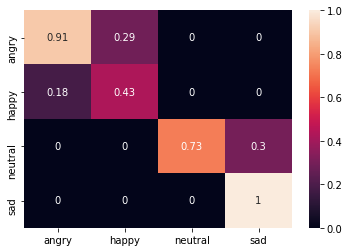

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(m.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Paper_2

In [ ]:
def findmaxsize(rslt_df):

    sizes = []
    for index, row in rslt_df.iterrows(): 
      filename = row['path']

      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
      #print(spect.shape)
      
      # Adding the size to the list
      sizes.append(spect.shape)
    print(f'The sizes of all the mel spectrograms in our data set are equal: {len(set(sizes)) == 1}')

    # Checking the max size
    print(f'The maximum size is: {max(sizes)}')


    return max(sizes)


X = pd.read_csv('EMO_DB/EMODB_details.csv',usecols=['labels','path'])
options = ['m_angry', 'm_happy','m_neutral','m_sad',
           'f_angry', 'f_happy','f_neutral','f_sad']

time = 4
rslt_df = X[X['labels'].isin(options)]


audio_files=[]
labels=[]
max_x,max_y = findmaxsize(rslt_df)

The sizes of all the mel spectrograms in our data set are equal: False
The maximum size is: (64, 898)


In [ ]:
max_x = 64
max_y = 898
T = 80
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

898 80 960 12


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(237, 12, 64, 80, 3) (237, 4)
(50, 12, 64, 80, 3) (50, 4)
(51, 12, 64, 80, 3) (51, 4)


In [ ]:
import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Reshape((36,256))(X)

    X= LSTM(256,return_sequences=True)(X)
    X= LSTM(256)(X)

    
    #X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    #X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    

    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)

      #cnn = Reshape((1,4096))(cnn)

      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    #lstm = LSTM(256,return_sequences=True)(output_layers)
    #lstm = LSTM(256,return_sequences=True)(lstm)
    #lstm = LSTM(256)(lstm)
    
    out = Dense(4,activation='softmax')(output_layers)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 64, 80,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 64, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 64, 80, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resizing (Resizing)             (None, 227, 227, 3)  0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_2_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_2_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 100s 1s/step - loss: 1.4743 - accuracy: 0.2469 - val_loss: 1.3035 - val_accuracy: 0.3725

Epoch 00001: val_loss improved from inf to 1.30351, saving model to EMODB//models/paper_2_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.37255, saving model to EMODB//models/paper_2_acc.h5
Epoch 2/30
30/30 [==============================] - 22s 744ms/step - loss: 1.2786 - accuracy: 0.3911 - val_loss: 1.2956 - val_accuracy: 0.3333

Epoch 00002: val_loss improved from 1.30351 to 1.29555, saving model to EMODB//models/paper_2_loss.h5

Epoch 00002: val_accuracy did not improve from 0.37255
Epoch 3/30
30/30 [==============================] - 22s 743ms/step - loss: 1.2599 - accuracy: 0.4450 - val_loss: 1.3521 - val_accuracy: 0.3333

Epoch 00003: val_loss did not improve from 1.29555

Epoch 00003: val_accuracy did not improve from 0.37255
Epoch 4/30
30/30 [==============================] - 22s 746ms/step - loss: 1.2901 - accuracy: 0.3929 - v

In [ ]:
p2.load_weights('EMODB//models//paper_2_acc.h5')
print(p2.evaluate(X_test_spec,Y_test_spec))
p2.load_weights('EMODB//models//paper_2_loss.h5')
p2.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 2s 869ms/step - loss: 0.9880 - accuracy: 0.6000
[0.9880372881889343, 0.6000000238418579]
2/2 [==============================] - 1s 385ms/step - loss: 0.9880 - accuracy: 0.6000


[0.9880372881889343, 0.6000000238418579]

F1 SCORE: 0.4220034351613299
Kappa: 0.3638676844783715
Accuracy: 0.6
Jaccard Score: 0.30567226890756305
Precision: 0.5207792207792208
Recall: 0.43863636363636366


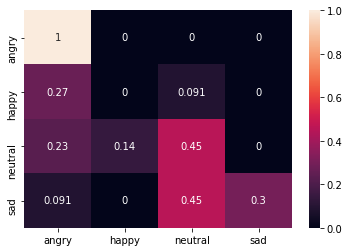

In [ ]:
#test set

g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p2.predict(X_test_spec),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p2.predict(X_test_spec),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

In [ ]:
0import keras
def AlexNet(input_shape):
    
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    
    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    return model

def paper_2():
    input_layer = Input((int(max_y/T)+1,max_x,T,3))
    alex = AlexNet((227,227,3))
    
    for i in range(int(max_y/T)+1):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer[:,i,:,:,:])
      
      cnn = alex(inp)
      cnn = Reshape((1,4096))(cnn)
      if i == 0:
        output_layers = cnn
      else:
        output_layers = Concatenate(axis = 1)([output_layers,cnn])
      
    
    #print(len(output_layers))
    lstm = LSTM(512,return_sequences=True)(output_layers)
    lstm = LSTM(512,return_sequences=True)(lstm)
    lstm = LSTM(512)(lstm)
    
    out = Dense(4,activation='softmax')(lstm)
    
    
    
    return Model(inputs=input_layer,outputs=out)
p2 = paper_2()
p2.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 12, 64, 80,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_39 (Sl (None, 64, 80, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_40 (Sl (None, 64, 80, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
resizing_39 (Resizing)          (None, 227, 227, 3)  0           tf.__operators__.getitem_39[0][0]
____________________________________________________________________________________________

In [ ]:
p2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_2_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_2_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p2.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 30s 672ms/step - loss: 1.8033 - accuracy: 0.2942 - val_loss: 1.4189 - val_accuracy: 0.2353

Epoch 00001: val_loss improved from inf to 1.41886, saving model to EMODB//models/paper_2_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.23529, saving model to EMODB//models/paper_2_acc.h5
Epoch 2/30
30/30 [==============================] - 18s 589ms/step - loss: 1.3838 - accuracy: 0.3058 - val_loss: 1.4771 - val_accuracy: 0.2549

Epoch 00002: val_loss did not improve from 1.41886

Epoch 00002: val_accuracy improved from 0.23529 to 0.25490, saving model to EMODB//models/paper_2_acc.h5
Epoch 3/30
30/30 [==============================] - 18s 591ms/step - loss: 1.3811 - accuracy: 0.3681 - val_loss: 1.4774 - val_accuracy: 0.2549

Epoch 00003: val_loss did not improve from 1.41886

Epoch 00003: val_accuracy did not improve from 0.25490
Epoch 4/30
30/30 [==============================] - 18s 589ms/step - loss: 1.3262 - accuracy: 0.4206 - 

# Paper 3

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
def paper_3():
  inp =  Input((time*16000,1))
  l1 = Conv1D(64,80,strides = 4,padding = 'same')(inp)
  m1 = MaxPooling1D(4)(l1)

  l2 = Conv1D(128,3,strides = 1,padding = 'same')(m1)
  l2 = Conv1D(128,3,strides = 1,padding = 'same')(l2)
  m2 = MaxPooling1D(4)(l2)

  l3 = Conv1D(256,3,strides = 1,padding = 'same')(m2)
  l3 = Conv1D(256,3,strides = 1,padding = 'same')(l3)
  m3 = MaxPooling1D(4)(l3)

  l4 = Conv1D(512,3,strides = 1,padding = 'same')(m3)
  l4 = Conv1D(512,3,strides = 1,padding = 'same')(l4)
  m4 = GlobalAveragePooling1D()(l4)

  f1 = Dense(1024)(m4)
  f2 = Dense(4, activation='softmax')(f1)

  return Model(inputs= inp,outputs=f2)

p3 = paper_3()
p3.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64000, 1)]        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         5184      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 128)         24704     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 128)         49280     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 256)         98560 

In [ ]:
p3.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_3_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_3_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p3.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 34s 45ms/step - loss: 1.4008 - accuracy: 0.3656 - val_loss: 1.2707 - val_accuracy: 0.4118

Epoch 00001: val_loss improved from inf to 1.27066, saving model to EMODB//models/paper_3_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.41176, saving model to EMODB//models/paper_3_acc.h5
Epoch 2/30
30/30 [==============================] - 1s 27ms/step - loss: 0.9869 - accuracy: 0.5252 - val_loss: 0.7496 - val_accuracy: 0.5490

Epoch 00002: val_loss improved from 1.27066 to 0.74961, saving model to EMODB//models/paper_3_loss.h5

Epoch 00002: val_accuracy improved from 0.41176 to 0.54902, saving model to EMODB//models/paper_3_acc.h5
Epoch 3/30
30/30 [==============================] - 1s 28ms/step - loss: 0.6952 - accuracy: 0.6893 - val_loss: 0.7737 - val_accuracy: 0.5882

Epoch 00003: val_loss did not improve from 0.74961

Epoch 00003: val_accuracy improved from 0.54902 to 0.58824, saving model to EMODB//models/paper_3_acc.h5
Epoch 4

In [ ]:
p3.load_weights('EMODB//models//paper_3_loss.h5')
print(p3.evaluate(X_test,Y_test))
p3.load_weights('EMODB//models//paper_3_loss.h5')
p3.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 165ms/step - loss: 0.5084 - accuracy: 0.8200
[0.5083817839622498, 0.8199999928474426]
2/2 [==============================] - 0s 22ms/step - loss: 0.5084 - accuracy: 0.8200


[0.5083817839622498, 0.8199999928474426]

2/2 [==============================] - 0s 34ms/step - loss: 0.5084 - accuracy: 0.8200
(50,) (50,)
F1 SCORE: 0.7866838539035335
Kappa: 0.7421203438395416
Accuracy: 0.82
Jaccard Score: 0.6641258741258742
Precision: 0.7893217893217893
Recall: 0.7860389610389611


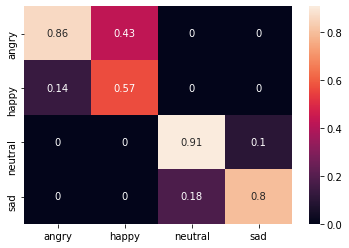

In [ ]:


p3.evaluate(X_test,Y_test)
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p3.predict(X_test).reshape(Y_test.shape[0],4),axis = -1)
print(g.shape,p.shape)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p3.predict(X_test).reshape(Y_test.shape[0],4),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

# Paper_4

In [ ]:
!pip install Signal_Analysis

     |████████████████████████████████| 378kB 4.2MB/s 
  Created wheel for Signal-Analysis: filename=Signal_Analysis-0.1.26-cp37-none-any.whl size=14538 sha256=7566079332a7bddd40555b6c2eed8c6d5cee5bd2356718e428a81ff99e8177c3
  Stored in directory: /root/.cache/pip/wheels/50/06/bb/04aa9ef50b93b5961b9817600ca1ff379f7091e63e09831655
Successfully built Signal-Analysis


In [ ]:
import numpy as np
import pandas as pd

import ast
import os
from tqdm.notebook import tqdm
import time

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Sound Processing
import librosa
from Signal_Analysis.features.signal import get_F_0, get_HNR

# Training Data Preparation
from sklearn.model_selection import train_test_split



import tensorflow as tf
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
import numpy as np
import librosa.display
import IPython.display as ipd

In [ ]:
NUM_EMOTIONS = 4
N_FFT = 4096
HOP_LENGTH = 1024
EMOTIONS = ['ang', 'hap', 'neu', 'sad']
SR = 16000


def extract_HSF(lld):
    mean_val = lld.mean()
    min_val = lld.min()
    max_val = lld.max()
    var_val = lld.var()
    range_val = np.subtract(max_val, min_val)
    q25_val = np.quantile(lld, 0.25)
    q50_val = np.quantile(lld, 0.5)
    q75_val = np.quantile(lld, 0.75)
    return np.asarray([
        mean_val,
        min_val,
        max_val,
        var_val,
        range_val,
        q25_val,
        q50_val,
        q75_val,
    ])

def extract_LLD_from_subaudio(subaudio, fs):
    # Frame-wise energy
    energy_val = np.sum(np.square(subaudio)) / (subaudio.shape[0] / fs + 0.00000000000001)
    
    # Frame-wise Zero Crossing Rate
    zcr_val = np.sum((subaudio[:-1] * subaudio[1:]) < 0)
    
    return np.asarray([
        energy_val,
        zcr_val,
    ])

def extract_LLD_from_audio(audio, fs):
    # MFCC
    mfcc = librosa.feature.mfcc(audio, fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False).transpose()
    mfcc_hsf = extract_HSF(mfcc)
    
    # LPC
    lpc = librosa.lpc(audio, 16)
    
    # Mel-Spectrogram
    spect = librosa.feature.melspectrogram(y = audio, sr = fs, n_fft = N_FFT, hop_length = HOP_LENGTH, center = False)
    spect = librosa.power_to_db(spect, ref = np.max).transpose()
    spect_hsf = extract_HSF(spect)
    
    # Other features
    f0 = get_F_0(audio, fs)[0]
    hnr = get_HNR(audio, fs)
    
    return np.asarray(mfcc), np.asarray(mfcc_hsf), np.asarray(lpc), np.asarray(spect), np.asarray(spect_hsf), np.asarray([f0, hnr])

def extract_LLD(audio, fs):
    #print(audio.shape)
    #print(int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1)
    num_windows = int((audio.shape[0] - N_FFT) // HOP_LENGTH) + 1
    framewise_lld = np.zeros((num_windows, 2))
    for idx in range(num_windows):
        subaudio = audio[int(idx * HOP_LENGTH): int(idx * HOP_LENGTH + N_FFT)]
        framewise_lld[idx, :] = extract_LLD_from_subaudio(subaudio, fs)
    framewise_lld_hsf = extract_HSF(framewise_lld)
    
    mfcc, mfcc_hsf, lpc, spect, spect_hsf, others = extract_LLD_from_audio(audio, fs)
    
    assert(framewise_lld.shape[0] == mfcc.shape[0])
    assert(mfcc.shape[0] == spect.shape[0])

    rnn_feats = np.concatenate((framewise_lld, mfcc, spect), axis = 1)
    dense_feats = np.concatenate((framewise_lld_hsf, mfcc_hsf, lpc, spect_hsf, others))
    return rnn_feats, dense_feats

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])
  X = []
  Y = []
  for index, row in rslt_df.iterrows(): 
    y = librosa.load(row['path'], mono=True, duration = 30,sr = SR)[0]
    y = librosa.util.fix_length(y,4*SR)
    rnn_feats, dense_feats = extract_LLD(y, SR)
    X.append(rnn_feats)
    Y.append(label_to_onehot(row['labels']))
    #print(rnn_feats.shape)

  X = np.reshape(np.array(X),(len(Y),X[0].shape[0],X[0].shape[1]))
  Y = np.reshape(np.array(Y),(X.shape[0],4))

  return X,Y



train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'numpy.float64'> 

<class 'nump

In [ ]:
X_train = np.expand_dims(X_train,axis = -1)
X_test = np.expand_dims(X_test,axis = -1)
X_val = np.expand_dims(X_val,axis = -1)

X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()
X_val = (X_val - X_val.mean())/X_val.std()

In [ ]:

def RNNSpeechModel(no_of_classes, input_size):
  
  # x = tf.keras.layers.Input((input_len,))
  # x = tf.keras.layers.Reshape((1,-1))(x)
  # m = Melspectrogram(n_dft=1024, n_hop=128, input_shape=(1, input_len),
  #                      padding='same', sr=sr, n_mels=80,
  #                      fmin=40.0, fmax=sr / 2, power_melgram=1.0,
  #                      return_decibel_melgram=True, trainable_fb=False,
  #                      trainable_kernel=False,
  #                      name='mel_stft')
  # m.trainable = False
  # x = m(x)
  #x = Normalization2D(int_axis=0)(x)
  #x = tf.keras.layers.Permute((2,1,3))(x)

  input = tf.keras.layers.Input((input_size))
  #Bidirectional RNN
  x = tf.keras.layers.Conv2D(10,(5,1),activation='relu',padding = 'same')(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(1,(5,1),activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Lambda(lambda q: K.squeeze(q, -1))(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)
  #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = 'true'))(x)

  #Attention unit
  xFirst = tf.keras.layers.Lambda(lambda q: q[:,-1])(x)
  query = tf.keras.layers.Dense(128)(xFirst)
  att_score = tf.keras.layers.Dot(axes=[1,2])([query,x])
  att_score = tf.keras.layers.Softmax()(att_score)

  #weighted pooling
  att_vector = tf.keras.layers.Dot(axes=[1,1])([att_score,x])
  #x = tf.keras.layers.Dense(64,activation='relu')(att_vector)
  #x = tf.keras.layers.Dense(32,activation='relu')(x)
  output = tf.keras.layers.Dense(no_of_classes,activation='softmax')(att_vector)

  model = tf.keras.models.Model(inputs = input,outputs = output)
  return model
  
no_of_classes = 4
input_size = X_train[0].shape
p4 = RNNSpeechModel(no_of_classes,input_size)
p4.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
p4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 59, 150, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 59, 150, 10)  60          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 59, 150, 10)  40          conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 59, 150, 1)   51          batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [ ]:
# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_4i_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_4i_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
p4.fit(X_train,Y_train, batch_size=8,validation_data=(X_val, Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 35s 78ms/step - loss: 1.3408 - acc: 0.4099 - val_loss: 1.2944 - val_acc: 0.5882

Epoch 00001: val_loss improved from inf to 1.29437, saving model to EMODB//models/paper_4i_loss.h5
Epoch 2/30
30/30 [==============================] - 1s 34ms/step - loss: 1.0564 - acc: 0.5998 - val_loss: 1.1465 - val_acc: 0.4314

Epoch 00002: val_loss improved from 1.29437 to 1.14651, saving model to EMODB//models/paper_4i_loss.h5
Epoch 3/30
30/30 [==============================] - 1s 34ms/step - loss: 0.9206 - acc: 0.6288 - val_loss: 0.9712 - val_acc: 0.6078

Epoch 00003: val_loss improved from 1.14651 to 0.97123, saving model to EMODB//models/paper_4i_loss.h5
Epoch 4/30
30/30 [==============================] - 1s 34ms/step - loss: 0.7359 - acc: 0.7063 - val_loss: 0.8242 - val_acc: 0.6275

Epoch 00004: val_loss improved from 0.97123 to 0.82421, saving model to EMODB//models/paper_4i_loss.h5
Epoch 5/30
30/30 [==============================] - 1s 34ms/ste

In [ ]:
p4.load_weights('EMODB//models//paper_4i_loss.h5')
p4.evaluate(X_test,Y_test)

2/2 [==============================] - 0s 63ms/step - loss: 0.6044 - acc: 0.7400


[0.6043654084205627, 0.7400000095367432]

F1 SCORE: 0.7020133053221289
Kappa: 0.6333897349125774
Accuracy: 0.74
Jaccard Score: 0.5693589743589744
Precision: 0.7244047619047619
Recall: 0.7025974025974027
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        22
           1       0.33      0.43      0.38         7
           2       0.71      0.91      0.80        11
           3       1.00      0.70      0.82        10

    accuracy                           0.74        50
   macro avg       0.72      0.70      0.70        50
weighted avg       0.78      0.74      0.75        50



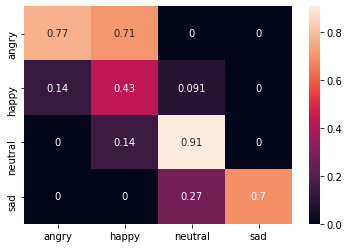

In [ ]:
#test set
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test,axis = -1)
p = np.argmax(p4.predict(X_test).reshape(Y_test.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# paper_5

In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot

def extract_mel_spectrogram(df,max_x = 64,max_y = 898):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = 64)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(0,int((max_y-64)/30),1):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*30:64 +i*30]
        delta = librosa.feature.delta(q).reshape((max_x,64,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,64,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,64,1))
        z = np.concatenate((q,delta,d_delta),axis = -1)
        s.append(z)

      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
print(X_val_spec.shape,Y_val_spec.shape)

(237, 27, 64, 64, 3) (237, 4)
(50, 27, 64, 64, 3) (50, 4)
(51, 27, 64, 64, 3) (51, 4)


In [ ]:
import keras
from sklearn.svm import SVC


def div_L0(num):
    [a, b] = div_L1(num)
    [c, d, e, f] = div_L2(num)

    return [a, b], [c, d, e, f]

    
def div_L1(num):
    a = num // 2
    b = num - a
    return [a, b]


def div_L2(num):
    [a, b] = div_L1(num)
    [c, d] = div_L1(a)
    [e, f] = div_L1(b)

    return [c, d, e, f]

def lpnorm_pooling(features_Ln):
    '''
    :param features_Ln:
    :param var_p: 1-average pooling, np.inf-max pooling
    :return:
    '''
    var_p = 2.14  # average pooling
#   var_p = np.inf  # max pooling
    lpnorm = tf.norm(features_Ln,ord=var_p,axis=1)
    result = lpnorm * (1/features_Ln.shape[1])**(1/var_p)

    #print(result)
    result = tf.math.reduce_max(features_Ln,axis = 1)
    #result = np.average(features_Ln,axis = 0)
    #print(result)

    return result

def subpart():
    
    input_layer = Input((227,227,3))

    X = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer)
    
      
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D(2)(X)
    
    X = Flatten()(X)
    
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 

    Y = Reshape((1,4096))(X)

    return Model(inputs = input_layer,outputs = Y)





def paper_2():
    input_layer = Input((27,64,64,3))

    sp = subpart()

    for i in range(input_layer.shape[1]):
      #print(input_layer[:,0,:,:,:].shape)
      inp = keras.layers.experimental.preprocessing.Resizing(227,227)(input_layer[:,i,:,:,:])
      output_layer = sp(inp)

      if i == 0:
        output_layers = output_layer
      else:
        output_layers = Concatenate(axis = 1)([output_layers,output_layer])
    
    print(output_layers.shape)
    t,n, d = output_layers.shape
    #rint(X.shape)

    if n == 3:
        features = np.row_stack((X, X[-1]))
    if n == 2:
        features = np.row_stack((X, X))
    if n == 1:
        print(n)
        features = tf.stack((X, X, X, X),axis =1)

    #print(features.shape)
    t,n, d = output_layers.shape

    [a, b], [c, d, e, f] = div_L0(n)

    L0 = lpnorm_pooling(output_layers)
    #print(a,b,c,d,e,f, features.shape)
    L1_1 = lpnorm_pooling(output_layers[:,:a,:])
    #print(features[:,:a,].shape)
    L1_2 = lpnorm_pooling(output_layers[:,a:,:])

    L2_1 = lpnorm_pooling(output_layers[:,:c,:])
    L2_2 = lpnorm_pooling(output_layers[:,c:a,:])
    L2_3 = lpnorm_pooling(output_layers[:,a:a+e,:])
    L2_4 = lpnorm_pooling(output_layers[:,a+e:,:])

    W_L0=1/4;
    W_L1=1/4;
    W_L2=1/2;

    Weights_L = [[W_L0,0,0,0,0,0,0],
                 [0,W_L1,0,0,0,0,0],
                 [0,0,W_L1,0,0,0,0],
                 [0,0,0,W_L2,0,0,0],
                 [0,0,0,0,W_L2,0,0],
                 [0,0,0,0,0,W_L2,0],
                 [0,0,0,0,0,0,W_L2]]

    features_Vp = Concatenate(axis =1)([W_L0*L0, W_L1*L1_1, W_L1*L1_2, W_L2*L2_1, W_L2*L2_2, W_L2*L2_3, W_L2*L2_4])

    op = Dense(4,activation = 'softmax',kernel_regularizer=keras.regularizers.l2(0.01))(features_Vp)
    #features_Up = np.matmul(Weights_L,features_Vp)

    return Model(inputs=input_layer,outputs=op)

p5 = paper_2()
p5.summary()

(None, 27, 4096)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 27, 64, 64,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_46 (Sl (None, 64, 64, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_47 (Sl (None, 64, 64, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
resizing_37 (Resizing)          (None, 227, 227, 3)  0           tf.__operators__.getitem_46[0][0]
___________________________________________________________________________

In [ ]:
p5.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_5_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_5_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p5.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 26s 589ms/step - loss: 14.6457 - accuracy: 0.2465 - val_loss: 1.3495 - val_accuracy: 0.3725

Epoch 00001: val_loss improved from inf to 1.34954, saving model to EMODB//models/paper_5_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.37255, saving model to EMODB//models/paper_5_acc.h5
Epoch 2/30
30/30 [==============================] - 16s 526ms/step - loss: 1.3352 - accuracy: 0.4076 - val_loss: 1.4382 - val_accuracy: 0.3529

Epoch 00002: val_loss did not improve from 1.34954

Epoch 00002: val_accuracy did not improve from 0.37255
Epoch 3/30
30/30 [==============================] - 16s 528ms/step - loss: 1.3690 - accuracy: 0.3956 - val_loss: 1.3443 - val_accuracy: 0.4118

Epoch 00003: val_loss improved from 1.34954 to 1.34430, saving model to EMODB//models/paper_5_loss.h5

Epoch 00003: val_accuracy improved from 0.37255 to 0.41176, saving model to EMODB//models/paper_5_acc.h5
Epoch 4/30
30/30 [==============================] -

In [ ]:
p5.load_weights('EMODB//models//paper_5_acc.h5')
print(p5.evaluate(X_test_spec,Y_test_spec))
p5.load_weights('EMODB//models//paper_5_loss.h5')
p5.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 1s 269ms/step - loss: 1.1365 - accuracy: 0.6000
[1.1364706754684448, 0.6000000238418579]
2/2 [==============================] - 1s 271ms/step - loss: 1.1289 - accuracy: 0.5600


[1.1289010047912598, 0.5600000023841858]

F1 SCORE: 0.6644570707070707
Kappa: 0.6453900709219859
Accuracy: 0.76
Jaccard Score: 0.5600288600288601
Precision: 0.6837412587412588
Recall: 0.6561688311688312
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        22
           1       0.20      0.14      0.17         7
           2       0.73      0.73      0.73        11
           3       1.00      0.80      0.89        10

    accuracy                           0.76        50
   macro avg       0.68      0.66      0.66        50
weighted avg       0.74      0.76      0.75        50



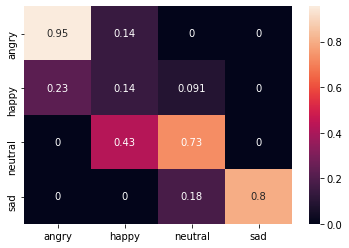

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p5.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# paper 6

In [ ]:
max_x = 96
max_y = 898
T = 64
print(max_y,T,(int(max_y/T)+1)*T,int(max_y/T)+1)

898 64 960 15


In [ ]:
label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot
def extract_mel_spectrogram(df,max_x = max_x,max_y = (int(max_y/T)+1)*T):
  labels = []
  mel_specs= []
  for index, row in df.iterrows():
      filename = row['path']
 
      y, sr = librosa.core.load(filename,sr = 16000)
      #print(y.shape)
      # Computing the mel spectrograms
      spect = librosa.feature.melspectrogram(y=y, sr=sr, window="hamming", win_length = int(0.025*sr),hop_length=int(0.010*sr),n_mels = max_x)
      
      spect = librosa.power_to_db(spect, ref=np.max)
 
            
      
      if spect.shape[1] != max_y:
                #print('Sizes arent same')
              spect.resize(max_x,max_y, refcheck=False)
      s=[]
      for i in range(int(max_y/T)):
        #print(spect[:,i*64:(i+1)*64].shape)
        q=spect[:,i*T:(i+1)*T]
        delta = librosa.feature.delta(q).reshape((max_x,T,1))
        d_delta = librosa.feature.delta(q,order = 2).reshape((max_x,T,1))
        #print(q.shape,delta.shape,d_delta.shape)
        q = q.reshape((max_x,T,1))

        z = np.concatenate((q,delta,d_delta),axis = -1)
        #print(z.shape)
        s.append(z)
      mel_specs.append(np.asarray(s))
      labels.append(label_to_onehot(row['labels']))
  #print(len(mel_specs),mel_specs[0].shape)
  mel_specs = np.asarray(mel_specs)
  labels = np.array(labels).reshape(len(labels),4)
  return mel_specs, labels
 
train_path = "EMO_DB//train.csv"
train_csv = pd.read_csv(train_path,usecols=['labels','path'])
X_train_spec,Y_train_spec = extract_mel_spectrogram(train_csv)
X_train_spec = (X_train_spec - X_train_spec.mean())/ X_train_spec.std()
#X_train_spec = np.expand_dims(X_train_spec,axis=-1)
print(X_train_spec.shape,Y_train_spec.shape)
 
 
test_path = "EMO_DB//test.csv"
test_csv = pd.read_csv(test_path,usecols=['labels','path'])
X_test_spec,Y_test_spec = extract_mel_spectrogram(test_csv)
X_test_spec = (X_test_spec - X_test_spec.mean())/ X_test_spec.std()
#X_test_spec = np.expand_dims(X_test_spec,axis=-1)
print(X_test_spec.shape,Y_test_spec.shape)
 
val_path = "EMO_DB//val.csv"
val_csv = pd.read_csv(val_path,usecols=['labels','path'])
X_val_spec,Y_val_spec = extract_mel_spectrogram(val_csv)
X_val_spec = (X_val_spec - X_val_spec.mean())/ X_val_spec.std()
#X_val_spec = np.expand_dims(X_val_spec,axis=-1)
print(X_val_spec.shape,Y_val_spec.shape)

(237, 15, 96, 64, 3) (237, 4)
(50, 15, 96, 64, 3) (50, 4)
(51, 15, 96, 64, 3) (51, 4)


In [ ]:
import keras

def VGG_net():
  input = Input((96,64,3))
  t = Conv2D(64, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(input)
  t = Conv2D(64, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(128, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(128, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(256, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = Conv2D(512, (3,3),padding = 'same', kernel_initializer = 'he_normal', activation = 'relu')(t)
  t = MaxPooling2D(2)(t)

  t = Flatten()(t)

  t = Dense(4096, activation = 'relu')(t)
  t = Dense(4096, activation = 'relu')(t)
  t = Dense(128, activation = 'relu')(t)

  t = Reshape((1,128))(t)

  return Model(inputs = input, outputs = t)


#change shape
def paper_6():
  ip = Input((15, 96,64,3))
  vgg = VGG_net()

  for i in range(ip.shape[1]):
    op_layer = vgg(ip[:,i,:,:,:])
    if i==0:
      op_layers = op_layer
    else:
      op_layers = Concatenate(axis = 1)([op_layers,op_layer])

  lstmb = Bidirectional(LSTM(256,return_sequences=True), merge_mode = 'sum')
  t = lstmb(op_layers)  
  lstmb2 = Bidirectional(LSTM(256,return_sequences=True), merge_mode = None)
  t2 = lstmb2(t)  

  h1 = t2[0]
  h2 = t2[1]
  print(h1.shape, h2.shape)
  h1 = Softmax(axis = -1)(h1)
  h2 = Softmax(axis =-1)(h2)
  

  sum1 = tf.keras.backend.sum(axis =1,x = h1)
  sum2 = tf.keras.backend.sum(axis =1,x= h2)
  sum = Concatenate()([sum1,sum2])
  print(sum.shape)

  mean1 = sum1/256.
  mean2 = sum2/256.
  mean = Concatenate()([mean1, mean2])

  std1 = tf.keras.backend.std(axis =1, x= h1)
  std2 =tf.keras.backend.std(axis =1, x =h2)
  std = Concatenate()([std1, std2])

  min1 = tf.keras.backend.min(axis =1,x=h1)
  min2 = tf.keras.backend.min(axis =1, x=h2)
  min = Concatenate()([min1, min2])

  max1 = tf.keras.backend.max(axis =1, x=h1)
  max2 = tf.keras.backend.max(axis=1, x =h2)
  max = Concatenate()([max1,max2])

  attention = Concatenate()([sum, mean, std, min, max])
  print(attention.shape)

  fc1 = Dense(512, activation = 'relu')(attention)
  fc2 = Dense(4, activation = 'softmax')(fc1)  


  return Model(inputs=ip,outputs=fc2)

p6 = paper_6()
p6.summary()

(None, 15, 256) (None, 15, 256)
(None, 512)
(None, 2560)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 96, 64,  0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 96, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 96, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 1, 128)       49917120    tf.__operators__.getitem[0][0]   
                                   

In [ ]:
p6.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMODB//models//paper_6_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMODB//models//paper_6_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
history = p6.fit(X_train_spec,Y_train_spec, batch_size=8,validation_data=(X_val_spec, Y_val_spec),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
30/30 [==============================] - 68s 771ms/step - loss: 1.3883 - accuracy: 0.2709 - val_loss: 1.4724 - val_accuracy: 0.2549

Epoch 00001: val_loss improved from inf to 1.47245, saving model to EMODB//models/paper_6_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.25490, saving model to EMODB//models/paper_6_acc.h5
Epoch 2/30
30/30 [==============================] - 18s 610ms/step - loss: 1.3691 - accuracy: 0.3534 - val_loss: 1.4676 - val_accuracy: 0.2549

Epoch 00002: val_loss improved from 1.47245 to 1.46764, saving model to EMODB//models/paper_6_loss.h5

Epoch 00002: val_accuracy did not improve from 0.25490
Epoch 3/30
30/30 [==============================] - 19s 620ms/step - loss: 1.3645 - accuracy: 0.3639 - val_loss: 1.4598 - val_accuracy: 0.2549

Epoch 00003: val_loss improved from 1.46764 to 1.45979, saving model to EMODB//models/paper_6_loss.h5

Epoch 00003: val_accuracy did not improve from 0.25490
Epoch 4/30
30/30 [==============================] -

In [ ]:
p6.load_weights('EMODB//models//paper_6_acc.h5')
print(p6.evaluate(X_test_spec,Y_test_spec))
p6.load_weights('EMODB//models//paper_6_loss.h5')
p6.evaluate(X_test_spec,Y_test_spec)

2/2 [==============================] - 4s 2s/step - loss: 1.3335 - accuracy: 0.4400
[1.3334697484970093, 0.4399999976158142]
2/2 [==============================] - 1s 277ms/step - loss: 1.3319 - accuracy: 0.4400


[1.3318769931793213, 0.4399999976158142]

F1 SCORE: 0.1527777777777778
Kappa: 0.0
Accuracy: 0.44
Jaccard Score: 0.11
Precision: 0.11
Recall: 0.25
              precision    recall  f1-score   support

           0       0.44      1.00      0.61        22
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11
           3       0.00      0.00      0.00        10

    accuracy                           0.44        50
   macro avg       0.11      0.25      0.15        50
weighted avg       0.19      0.44      0.27        50



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


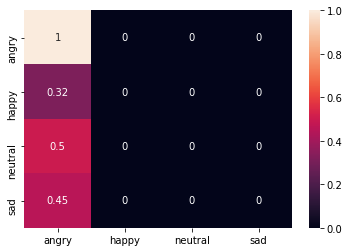

In [ ]:
#test set
#p2.load_weights('TESS//models//paper_2_acc.h5')
from sklearn.metrics import *

cf_matrix = confusion_matrix(np.argmax(Y_test_spec,axis = -1),np.argmax(p6.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())
g = np.argmax(Y_test_spec,axis = -1)
p = np.argmax(p6.predict(X_test_spec).reshape(Y_test_spec.shape),axis = 1)
g = g.ravel()
p = p.ravel()
f1 = f1_score(g,p,average= 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average='macro')
precision = precision_score(g,p,average='macro') 
recall = recall_score(g,p,average='macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)

print(classification_report(g,p))

# Jan 2022

## Ensembled

In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

## Testing on TESS

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "TESS//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "TESS//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "TESS//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (1114, 64000, 1) (1114, 4)
Test Data (239, 64000, 1) (239, 4)
Val Data (239, 64000, 1) (239, 4)


In [ ]:
csvpath = 'TESS/hand_engineered_features_TESS_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'TESS/hand_engineered_features_TESS_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)

print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(1114, 26) (1114, 1)
(239, 26) (239, 1)
(239, 26) (239, 1)


In [ ]:
#print(ensembled.evaluate([X_test,X_test_features],Y_test))
ensembled.load_weights("EMO_DB//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("EMO_DB//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

8/8 [==============================] - 12s 190ms/step - loss: 3.0839 - accuracy: 0.3849
[3.083902597427368, 0.38493722677230835]
8/8 [==============================] - 1s 153ms/step - loss: 2.0765 - accuracy: 0.4100


[2.076495885848999, 0.41004183888435364]

8/8 [==============================] - 1s 158ms/step - loss: 2.0765 - accuracy: 0.4100
[2.076495885848999, 0.41004183888435364]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 SCORE: 0.35266798418972334
Kappa: 0.21980413492927098
Accuracy: 0.4100418410041841
Jaccard Score: 0.24258524737567372
Precision: 0.31233822903363134
Recall: 0.4142538806694155


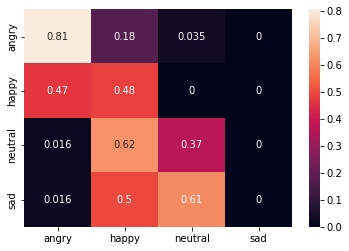

In [ ]:
#test set
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


## Testing on Crema D

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      y, sr = librosa.load(row['path'], mono=True, duration = 4,sr = 16000)      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "CREMA//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "CREMA//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "CREMA//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (3430, 64000, 1) (3430, 4)
Test Data (735, 64000, 1) (735, 4)
Val Data (735, 64000, 1) (735, 4)


In [ ]:
csvpath = 'CREMA/hand_engineered_features_CREMA_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'CREMA/hand_engineered_features_CREMA_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(3430, 26) (3430, 1)
(735, 26) (735, 1)
(735, 26) (735, 1)


In [ ]:
#print(ensembled.evaluate([X_test,X_test_features],Y_test))
ensembled.load_weights("EMO_DB//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("EMO_DB//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

23/23 [==============================] - 4s 185ms/step - loss: 3.3563 - accuracy: 0.3687
[3.356342315673828, 0.36870747804641724]
23/23 [==============================] - 4s 160ms/step - loss: 2.4289 - accuracy: 0.3551


[2.42889404296875, 0.3551020324230194]

23/23 [==============================] - 4s 159ms/step - loss: 2.4289 - accuracy: 0.3551
[2.42889404296875, 0.3551020324230194]
F1 SCORE: 0.30307083624248216
Kappa: 0.13290524901067713
Accuracy: 0.3551020408163265
Jaccard Score: 0.19211782815760478
Precision: 0.516602733686067
Recall: 0.34926875143150204


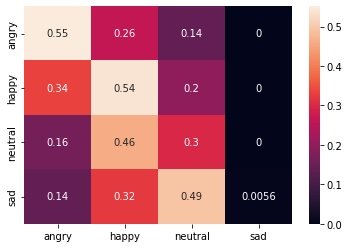

In [ ]:
#test set
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


## Testing on SAVEE( manipulation on time var) ⚛

In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    #l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "SAVEE//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "SAVEE//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "SAVEE//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (207, 64000, 1) (207, 4)
Test Data (45, 64000, 1) (45, 4)
Val Data (44, 64000, 1) (44, 4)


In [ ]:
csvpath = 'SAVEE/hand_engineered_features_SAVEE_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'SAVEE/hand_engineered_features_SAVEE_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(207, 26) (207, 1)
(45, 26) (45, 1)
(44, 26) (44, 1)


In [ ]:
#print(ensembled.evaluate([X_test,X_test_features],Y_test))
ensembled.load_weights("EMO_DB//models/ensembled_loss.h5")
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights("EMO_DB//models/ensembled_acc.h5")
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 384ms/step - loss: 2.1133 - accuracy: 0.4667
[2.11334228515625, 0.46666666865348816]
2/2 [==============================] - 0s 77ms/step - loss: 1.4076 - accuracy: 0.5778


[1.4075660705566406, 0.5777778029441833]

2/2 [==============================] - 0s 104ms/step - loss: 1.4076 - accuracy: 0.5778
[1.4075660705566406, 0.5777778029441833]
F1 SCORE: 0.5727875243664717
Kappa: 0.44444444444444453
Accuracy: 0.5777777777777777
Jaccard Score: 0.4101762820512821
Precision: 0.5944444444444444
Recall: 0.6150793650793651


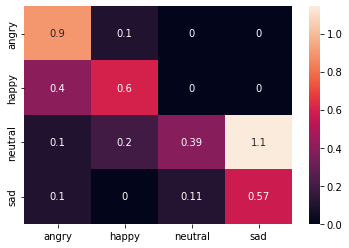

In [ ]:
#test set
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1)

g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]).reshape(Y_test.shape),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())


# Feb 2022

## Hamming Window

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,window="hamming")
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr,window="hamming")
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr,window="hamming")
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr,window="hamming")
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,window="hamming")
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hamming_hand_engineered_features_EMODB_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hamming_hand_engineered_features_EMODB_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hamming_hand_engineered_features_EMODB_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB/hamming_hand_engineered_features_EMODB_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB/hamming_hand_engineered_features_EMODB_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB/hamming_hand_engineered_features_EMODB_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 26) (237, 1)
(50, 26) (50, 1)
(51, 26) (51, 1)


In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (26))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled = Wavenet()
ensembled.summary()

ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
ensembled.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_hamming_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_hamming_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.1737 - accuracy: 0.5992
Epoch 00001: val_loss improved from inf to 0.96931, saving model to EMO_DB//models/ensembled_hamming_loss.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: val_accuracy improved from -inf to 0.66667, saving model to EMO_DB//models/ensembled_hamming_acc.h5
15/15 [==============================] - 25s 485ms/step - loss: 1.1737 - accuracy: 0.5992 - val_loss: 0.9693 - val_accuracy: 0.6667
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.8389 - accuracy: 0.7595
Epoch 00002: val_loss improved from 0.96931 to 0.76569, saving model to EMO_DB//models/ensembled_hamming_loss.h5

Epoch 00002: val_accuracy improved from 0.66667 to 0.70588, saving model to EMO_DB//models/ensembled_hamming_acc.h5
15/15 [==============================] - 4s 260ms/step - loss: 0.8389 - accuracy: 0.7595 - val_loss: 0.7657 - val_accuracy: 0.7059
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.6346 - accuracy: 0.7890
Epoch 00003: val_loss improved from 0.76569 to 0.62904, saving model to EMO_DB//models/ensembled_hamming_loss.h5

Epoch 00003: val_accuracy improved from 0.70588 to 0.76471, saving model to EMO_DB//models/

In [ ]:
ensembled.load_weights('EMO_DB//models//ensembled_hamming_loss.h5')
print(ensembled.evaluate([X_test,X_test_features],Y_test))

ensembled.load_weights('EMO_DB//models//ensembled_hamming_acc.h5')
ensembled.evaluate([X_test,X_test_features],Y_test)

2/2 [==============================] - 1s 414ms/step - loss: 0.1403 - accuracy: 0.9400
[0.1403397023677826, 0.9399999976158142]
2/2 [==============================] - 0s 114ms/step - loss: 0.1685 - accuracy: 0.9400


[0.16848304867744446, 0.9399999976158142]

2/2 [==============================] - 0s 126ms/step - loss: 0.1403 - accuracy: 0.9400
[0.1403397023677826, 0.9399999976158142]
F1 SCORE: 0.9291125541125542
Kappa: 0.9141385231825987
Accuracy: 0.94
Jaccard Score: 0.870306324110672
Precision: 0.9301948051948052
Recall: 0.9301948051948052


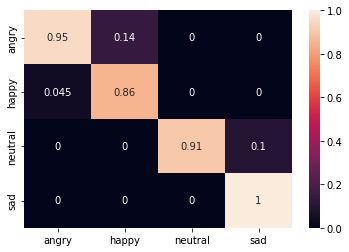

In [ ]:
ensembled.load_weights('EMO_DB//models//ensembled_hamming_loss.h5')
print(ensembled.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## without mfcc's

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_without_mfcc_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_without_mfcc_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_without_mfcc_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_without_mfcc_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_without_mfcc_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_without_mfcc_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 6) (237, 1)
(50, 6) (50, 1)
(51, 6) (51, 1)


In [ ]:
label_dict = {
      'angry':(1,0,0,0),
      'happy':(0,1,0,0),
      'neutral':(0,0,1,0),
      'sad':(0,0,0,1)
  }
time = 4
def label_to_onehot(l):
    l=l[2:]
    onehot = label_dict[l]
    return onehot
def load_csv(path):
  audio_files=[]
  labels=[]

  rslt_df = pd.read_csv(path,usecols=['labels','path'])

  for index, row in rslt_df.iterrows(): 
      
      y, sr = librosa.load(row['path'], mono=True, duration = time,sr = 16000)
      
      audio_files.append(librosa.util.fix_length(y,int(sr*time)))
      labels.append(label_to_onehot(row['labels']))

  audio_files = np.reshape(np.array(audio_files),(len(labels),int(sr*time),1))
  labels = np.array(labels)

  return audio_files,labels

train_path = "EMO_DB//train.csv"
X_train,Y_train = load_csv(train_path)
print("Train Data",X_train.shape,Y_train.shape)

test_path = "EMO_DB//test.csv"
X_test,Y_test = load_csv(test_path)
print("Test Data",X_test.shape,Y_test.shape)

val_path = "EMO_DB//val.csv"
X_val,Y_val = load_csv(val_path)
print("Val Data",X_val.shape,Y_val.shape)

Train Data (237, 64000, 1) (237, 4)
Test Data (50, 64000, 1) (50, 4)
Val Data (51, 64000, 1) (51, 4)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (6))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_withoutmfcc = Wavenet()
ensembled_withoutmfcc.summary()

ensembled_withoutmfcc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
ensembled_withoutmfcc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_withoutmfcc_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_withoutmfcc_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_withoutmfcc.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.2972 - accuracy: 0.4979
Epoch 1: val_loss improved from inf to 1.23943, saving model to EMO_DB//models/ensembled_withoutmfcc_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.43137, saving model to EMO_DB//models/ensembled_withoutmfcc_acc.h5
15/15 [==============================] - 23s 453ms/step - loss: 1.2972 - accuracy: 0.4979 - val_loss: 1.2394 - val_accuracy: 0.4314
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 1.1103 - accuracy: 0.5738
Epoch 2: val_loss improved from 1.23943 to 1.12699, saving model to EMO_DB//models/ensembled_withoutmfcc_loss.h5

Epoch 2: val_accuracy improved from 0.43137 to 0.56863, saving model to EMO_DB//models/ensembled_withoutmfcc_acc.h5
15/15 [==============================] - 4s 274ms/step - loss: 1.1103 - accuracy: 0.5738 - val_loss: 1.1270 - val_accuracy: 0.5686
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.9875 - accuracy: 0.6287
Ep

2/2 [==============================] - 15s 460ms/step - loss: 0.4038 - accuracy: 0.8200
[0.40375038981437683, 0.8199999928474426]
F1 SCORE: 0.8070842868039665
Kappa: 0.7512437810945274
Accuracy: 0.82
Jaccard Score: 0.6839084828215263
Precision: 0.8147824397824397
Recall: 0.8392857142857142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


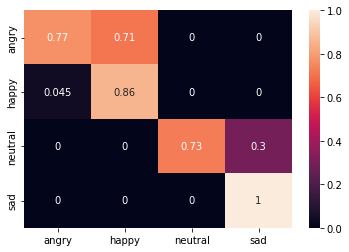

In [ ]:
ensembled_withoutmfcc.load_weights('EMO_DB//models//ensembled_withoutmfcc_loss.h5')
print(ensembled_withoutmfcc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_withoutmfcc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_withoutmfcc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 131ms/step - loss: 0.3765 - accuracy: 0.8200
[0.37652450799942017, 0.8199999928474426]
F1 SCORE: 0.8070842868039665
Kappa: 0.7512437810945274
Accuracy: 0.82
Jaccard Score: 0.6839084828215263
Precision: 0.8147824397824397
Recall: 0.8392857142857142


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


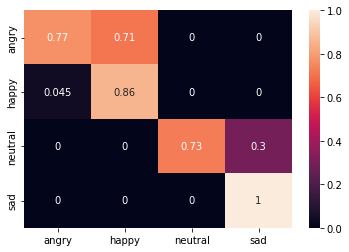

In [ ]:
ensembled_withoutmfcc.load_weights('EMO_DB//models//ensembled_withoutmfcc_acc.h5')
print(ensembled_withoutmfcc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_withoutmfcc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_withoutmfcc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## only MFCCs

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' '    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 20) (237, 1)
(50, 20) (50, 1)
(51, 20) (51, 1)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (20))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_onlymfcc = Wavenet()
ensembled_onlymfcc.summary()

ensembled_onlymfcc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 64000, 8)     48          ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 64000, 8)     0           ['conv1d_42[0][0]']              
                                                                                                  
 conv1d_43 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_16[0][0]']         
                                                                                            

In [ ]:
ensembled_onlymfcc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_onlymfcc_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_onlymfcc_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_onlymfcc.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.2968 - accuracy: 0.4262
Epoch 1: val_loss improved from inf to 1.11284, saving model to EMO_DB//models/ensembled_onlymfcc_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.64706, saving model to EMO_DB//models/ensembled_onlymfcc_acc.h5
15/15 [==============================] - 18s 509ms/step - loss: 1.2968 - accuracy: 0.4262 - val_loss: 1.1128 - val_accuracy: 0.6471
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.9546 - accuracy: 0.7975
Epoch 2: val_loss improved from 1.11284 to 0.84750, saving model to EMO_DB//models/ensembled_onlymfcc_loss.h5

Epoch 2: val_accuracy improved from 0.64706 to 0.76471, saving model to EMO_DB//models/ensembled_onlymfcc_acc.h5
15/15 [==============================] - 4s 300ms/step - loss: 0.9546 - accuracy: 0.7975 - val_loss: 0.8475 - val_accuracy: 0.7647
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.7201 - accuracy: 0.8059
Epoch 3: val_l

2/2 [==============================] - 0s 124ms/step - loss: 0.0609 - accuracy: 0.9800
[0.06085257977247238, 0.9800000190734863]
F1 SCORE: 0.9761904761904763
Kappa: 0.9713795077275329
Accuracy: 0.98
Jaccard Score: 0.9545454545454546
Precision: 0.9772727272727273
Recall: 0.9772727272727273


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


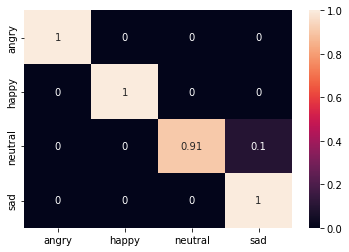

In [ ]:
ensembled_onlymfcc.load_weights('EMO_DB//models//ensembled_onlymfcc_acc.h5')
print(ensembled_onlymfcc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_onlymfcc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_onlymfcc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## only MFCC + chroma stft + rmse

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_chromastft_rmse_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_chromastft_rmse_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_chromastft_rmse_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_chromastft_rmse_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_chromastft_rmse_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_only_mfcc_chromastft_rmse_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 22) (237, 1)
(50, 22) (50, 1)
(51, 22) (51, 1)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (22))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_onlymfcc_chromastft_rmse = Wavenet()
ensembled_onlymfcc_chromastft_rmse.summary()

ensembled_onlymfcc_chromastft_rmse.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_63 (Conv1D)             (None, 64000, 8)     48          ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_24 (LeakyReLU)     (None, 64000, 8)     0           ['conv1d_63[0][0]']              
                                                                                                  
 conv1d_64 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_24[0][0]']         
                                                                                            

In [ ]:
ensembled_onlymfcc_chromastft_rmse.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_onlymfcc_chromastft_rmse_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_onlymfcc_chromastft_rmse_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_onlymfcc_chromastft_rmse.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.2453 - accuracy: 0.5274
Epoch 1: val_loss improved from inf to 0.98708, saving model to EMO_DB//models/ensembled_onlymfcc_chromastft_rmse_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.78431, saving model to EMO_DB//models/ensembled_onlymfcc_chromastft_rmse_acc.h5
15/15 [==============================] - 14s 422ms/step - loss: 1.2453 - accuracy: 0.5274 - val_loss: 0.9871 - val_accuracy: 0.7843
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.8770 - accuracy: 0.7342
Epoch 2: val_loss improved from 0.98708 to 0.76336, saving model to EMO_DB//models/ensembled_onlymfcc_chromastft_rmse_loss.h5

Epoch 2: val_accuracy did not improve from 0.78431
15/15 [==============================] - 4s 293ms/step - loss: 0.8770 - accuracy: 0.7342 - val_loss: 0.7634 - val_accuracy: 0.7647
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.7806
Epoch 3: val_loss improved f

2/2 [==============================] - 0s 128ms/step - loss: 0.1596 - accuracy: 0.9200
[0.1596069484949112, 0.9200000166893005]
F1 SCORE: 0.9085306795806503
Kappa: 0.8863636363636364
Accuracy: 0.92
Jaccard Score: 0.8382246376811594
Precision: 0.9047619047619048
Recall: 0.9165584415584415


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


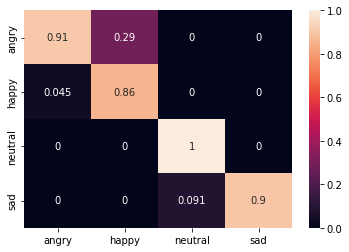

In [ ]:
ensembled_onlymfcc_chromastft_rmse.load_weights('EMO_DB//models//ensembled_onlymfcc_chromastft_rmse_acc.h5')
print(ensembled_onlymfcc_chromastft_rmse.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_onlymfcc_chromastft_rmse.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_onlymfcc_chromastft_rmse.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 133ms/step - loss: 0.1431 - accuracy: 0.9200
[0.1431337296962738, 0.9200000166893005]
F1 SCORE: 0.9087486157253599
Kappa: 0.8864926220204313
Accuracy: 0.92
Jaccard Score: 0.8386034255599473
Precision: 0.9028679653679654
Recall: 0.9188311688311688


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


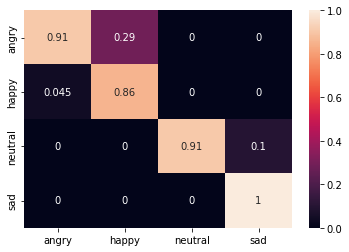

In [ ]:
ensembled_onlymfcc_chromastft_rmse.load_weights('EMO_DB//models//ensembled_onlymfcc_chromastft_rmse_loss.h5')
print(ensembled_onlymfcc_chromastft_rmse.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_onlymfcc_chromastft_rmse.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_onlymfcc_chromastft_rmse.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## last shot (- (zcr + roll off))

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    #header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        #zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        #to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_without_zcr_rolloff_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_without_zcr_rolloff_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_without_zcr_rolloff_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_without_zcr_rolloff_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_without_zcr_rolloff_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_without_zcr_rolloff_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 24) (237, 1)
(50, 24) (50, 1)
(51, 24) (51, 1)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (24))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_lastshot = Wavenet()
ensembled_lastshot.summary()

ensembled_lastshot.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 64000, 8)     48          ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 64000, 8)     0           ['conv1d_21[0][0]']              
                                                                                                  
 conv1d_22 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_8[0][0]']          
                                                                                            

In [ ]:
ensembled_lastshot.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_lastshot_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_lastshot_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_lastshot.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.1641 - accuracy: 0.6034
Epoch 1: val_loss improved from inf to 0.97326, saving model to EMO_DB//models/ensembled_lastshot_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.62745, saving model to EMO_DB//models/ensembled_lastshot_acc.h5
15/15 [==============================] - 24s 459ms/step - loss: 1.1641 - accuracy: 0.6034 - val_loss: 0.9733 - val_accuracy: 0.6275
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.7300
Epoch 2: val_loss improved from 0.97326 to 0.71806, saving model to EMO_DB//models/ensembled_lastshot_loss.h5

Epoch 2: val_accuracy improved from 0.62745 to 0.74510, saving model to EMO_DB//models/ensembled_lastshot_acc.h5
15/15 [==============================] - 4s 279ms/step - loss: 0.8152 - accuracy: 0.7300 - val_loss: 0.7181 - val_accuracy: 0.7451
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.8101
Epoch 3: val_l

2/2 [==============================] - 1s 404ms/step - loss: 0.1231 - accuracy: 0.9600
[0.12308147549629211, 0.9599999785423279]
F1 SCORE: 0.9537098560354376
Kappa: 0.9432463110102156
Accuracy: 0.96
Jaccard Score: 0.9119318181818182
Precision: 0.9460227272727273
Recall: 0.9659090909090909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


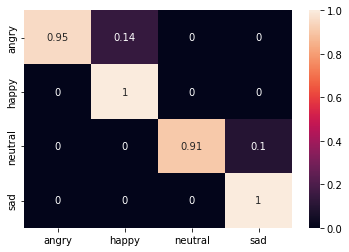

In [ ]:
ensembled_lastshot.load_weights('EMO_DB//models//ensembled_lastshot_loss.h5')
print(ensembled_lastshot.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_lastshot.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_lastshot.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 102ms/step - loss: 0.2647 - accuracy: 0.9200
[0.26474544405937195, 0.9200000166893005]
F1 SCORE: 0.894927536231884
Kappa: 0.8834498834498835
Accuracy: 0.92
Jaccard Score: 0.835
Precision: 0.91875
Recall: 0.8814935064935066


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


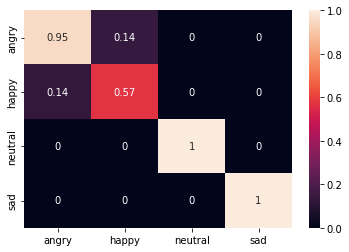

In [ ]:
ensembled_lastshot.load_weights('EMO_DB//models//ensembled_lastshot_acc.h5')
print(ensembled_lastshot.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_lastshot.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_lastshot.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## MFCC  + chroma stft + rmse + spectral bw + zcr

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_bandwidth zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        #rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_bw)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_rolloff_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_rolloff_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_rolloff_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_rolloff_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_minus_sc_rolloff_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_minus_sc_rolloff_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (24))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_minusscro = Wavenet()
ensembled_minusscro.summary()

ensembled_minusscro.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 64000, 8)     48          ['input_5[0][0]']                
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 64000, 8)     0           ['conv1d_42[0][0]']              
                                                                                                  
 conv1d_43 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_16[0][0]']         
                                                                                            

In [ ]:
ensembled_minusscro.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_minusscro_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_minusscro_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_minusscro.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.1938 - accuracy: 0.5316
Epoch 1: val_loss improved from inf to 0.97015, saving model to EMO_DB//models/ensembled_minusscro_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.72549, saving model to EMO_DB//models/ensembled_minusscro_acc.h5
15/15 [==============================] - 11s 370ms/step - loss: 1.1938 - accuracy: 0.5316 - val_loss: 0.9702 - val_accuracy: 0.7255
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.8407 - accuracy: 0.7257
Epoch 2: val_loss improved from 0.97015 to 0.74949, saving model to EMO_DB//models/ensembled_minusscro_loss.h5

Epoch 2: val_accuracy improved from 0.72549 to 0.78431, saving model to EMO_DB//models/ensembled_minusscro_acc.h5
15/15 [==============================] - 4s 270ms/step - loss: 0.8407 - accuracy: 0.7257 - val_loss: 0.7495 - val_accuracy: 0.7843
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.6426 - accuracy: 0.8017
Epoch 3: v

2/2 [==============================] - 0s 129ms/step - loss: 0.1296 - accuracy: 0.9400
[0.1296497881412506, 0.9399999976158142]
F1 SCORE: 0.9234363081617087
Kappa: 0.912536443148688
Accuracy: 0.94
Jaccard Score: 0.8619047619047618
Precision: 0.9583333333333333
Recall: 0.9035714285714286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


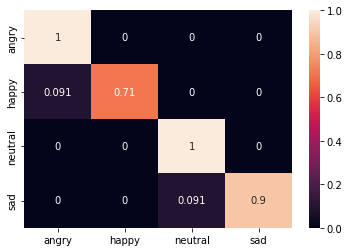

In [ ]:
ensembled_minusscro.save_weights('EMO_DB//models//ensembled_minusscro.h5')
print(ensembled_minusscro.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minusscro.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minusscro.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 102ms/step - loss: 0.1440 - accuracy: 0.9400
[0.14403213560581207, 0.9399999976158142]
F1 SCORE: 0.9236542443064182
Kappa: 0.912638322655795
Accuracy: 0.94
Jaccard Score: 0.8622835497835498
Precision: 0.9564393939393939
Recall: 0.9058441558441559


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


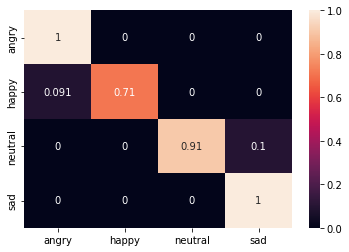

In [ ]:
ensembled_minusscro.load_weights('EMO_DB//models//ensembled_minusscro_loss.h5')
print(ensembled_minusscro.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minusscro.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minusscro.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 102ms/step - loss: 0.1909 - accuracy: 0.9200
[0.19090396165847778, 0.9200000166893005]
F1 SCORE: 0.9018315018315017
Kappa: 0.8845265588914549
Accuracy: 0.92
Jaccard Score: 0.8295454545454546
Precision: 0.9138669301712781
Recall: 0.8944805194805195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


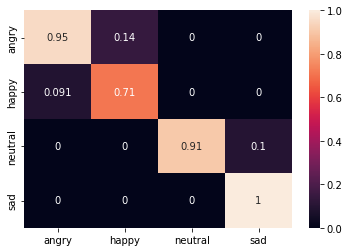

In [ ]:
ensembled_minusscro.load_weights('EMO_DB//models//ensembled_minusscro_acc.h5')
print(ensembled_minusscro.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minusscro.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minusscro.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## MFCC  + chroma stft + rmse + spectral bw + roll off

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_bandwidth rolloff'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        #zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_bw)} {np.mean(rolloff)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_zcr_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_zcr_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_zcr_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_zcr_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_minus_sc_zcr_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_minus_sc_zcr_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 24) (237, 1)
(50, 24) (50, 1)
(51, 24) (51, 1)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (24))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_minussczcr = Wavenet()
ensembled_minussczcr.summary()

ensembled_minussczcr.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 64000, 8)     48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64000, 8)     0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64000, 8)     328         ['leaky_re_lu[0][0]']            
                                                                                              

In [ ]:
ensembled_minussczcr.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_minussczcr_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_minussczcr_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_minussczcr.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.1911 - accuracy: 0.5190
Epoch 1: val_loss improved from inf to 0.97256, saving model to EMO_DB//models/ensembled_minussczcr_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to EMO_DB//models/ensembled_minussczcr_acc.h5
15/15 [==============================] - 21s 427ms/step - loss: 1.1911 - accuracy: 0.5190 - val_loss: 0.9726 - val_accuracy: 0.7059
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.8396 - accuracy: 0.7468
Epoch 2: val_loss improved from 0.97256 to 0.75326, saving model to EMO_DB//models/ensembled_minussczcr_loss.h5

Epoch 2: val_accuracy improved from 0.70588 to 0.78431, saving model to EMO_DB//models/ensembled_minussczcr_acc.h5
15/15 [==============================] - 4s 249ms/step - loss: 0.8396 - accuracy: 0.7468 - val_loss: 0.7533 - val_accuracy: 0.7843
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.8101
Epoch 

2/2 [==============================] - 1s 461ms/step - loss: 0.1147 - accuracy: 0.9600
[0.11469070613384247, 0.9599999785423279]
F1 SCORE: 0.9537098560354376
Kappa: 0.9432463110102156
Accuracy: 0.96
Jaccard Score: 0.9119318181818182
Precision: 0.9460227272727273
Recall: 0.9659090909090909


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


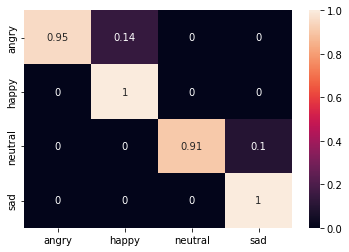

In [ ]:
ensembled_minussczcr.load_weights('EMO_DB//models//ensembled_minussczcr_loss.h5')
print(ensembled_minussczcr.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minussczcr.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minussczcr.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 111ms/step - loss: 0.1773 - accuracy: 0.9200
[0.17726950347423553, 0.9200000166893005]
F1 SCORE: 0.9018315018315017
Kappa: 0.8845265588914549
Accuracy: 0.92
Jaccard Score: 0.8295454545454546
Precision: 0.9138669301712781
Recall: 0.8944805194805195


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


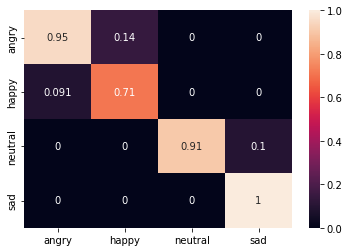

In [ ]:
ensembled_minussczcr.load_weights('EMO_DB//models//ensembled_minussczcr_acc.h5')
print(ensembled_minussczcr.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minussczcr.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minussczcr.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

## MINUS sc

In [ ]:
#angry, happy, neutral, sad
import csv

label_dict = {
    'angry':(1,0,0,0),
    'happy':(0,1,0,0),
    'neutral':(0,0,1,0),
    'sad':(0,0,0,1)
}

def label_to_onehot(l):
  l=l[2:]
  onehot = label_dict[l]
  return onehot


def extract_features(csvpath,path):
    header = 'filename chroma_stft rmse spectral_bandwidth rolloff zero_crossing_rate'
    for i in range(1, 21):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file = open(csvpath, 'w', newline='')
    with file:
      writer = csv.writer(file)
      writer.writerow(header)
    rslt_df = pd.read_csv(path,usecols=['labels','path'])
    for index, row in rslt_df.iterrows(): 
        filename = row['path']
        y, sr = librosa.load(row['path'], mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        #spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f' {filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
                    to_append += f' {np.mean(e)}'
        onehot_label = label_to_onehot(row['labels'])
        to_append += f' {np.argmax(onehot_label)}'
        file = open(csvpath, 'a', newline='')
        with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())

train_csv = "EMO_DB//train.csv"
test_csv = "EMO_DB//test.csv"
val_csv = "EMO_DB//val.csv"
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_train.csv'
extract_features(csvpath,train_csv)
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_test.csv'
extract_features(csvpath,test_csv)
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_val.csv'
extract_features(csvpath,val_csv)

In [ ]:
csvpath = 'EMO_DB//hand_engineered_features_minus_sc_train.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
scaler = StandardScaler()
scaler = scaler.fit(np.array(data.iloc[:, :-1], dtype = float))
X_train_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_train_features = np.array(data.iloc[:, -1]).reshape(X_train_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_minus_sc_test.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_test_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_test_features = np.array(data.iloc[:, -1]).reshape(X_test_features.shape[0],1)

csvpath = 'EMO_DB//hand_engineered_features_minus_sc_val.csv'
data = pd.read_csv(csvpath)
data = data.drop(['filename'],axis=1)
X_val_features = scaler.transform(np.array(data.iloc[:, :-1], dtype = float))
Y_val_features = np.array(data.iloc[:, -1]).reshape(X_val_features.shape[0],1)



print(X_train_features.shape,Y_train_features.shape)
print(X_test_features.shape,Y_test_features.shape)
print(X_val_features.shape,Y_val_features.shape)

(237, 25) (237, 1)
(50, 25) (50, 1)
(51, 25) (51, 1)


In [ ]:
time = 4
def self_attention(b5):
    b5 = Permute(dims = (2,1))(b5)
    w,x,z = b5.shape
    z1=int(z)
    query = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)            #can change the factor to divide 
    key = Conv1D(z1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)
    value = Conv1D(z, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b5)

    query = Reshape([x, z1])(query)
    key = Reshape([z1, x])(key)
    value = Reshape([z, x])(value)

    prod = Dot(axes = 2)([query,Permute(dims = (2,1))(key)])

    w = z1**-2
    prod = Lambda(lambda x: x * w)(prod)
    prod = Softmax()(prod)
    
    attention = Dot(axes = 2)([value,Permute(dims = (2,1))(prod)])
    attention = Reshape([x,z])(attention)
    attention = Add()([attention,b5])
    attention = Permute(dims = (2,1))(attention)
    return attention


def Wavenet():
  n_filters = 64
  filter_width = 2
  dilation_rates = [2**i for i in range(3)]  
  sr = 16000

  ip1 = Input(shape=(int(sr*time), 1))
  


  x = LeakyReLU()(Conv1D(8,5,padding='same')(ip1))
  x = LeakyReLU()(Conv1D(8,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)

  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = LeakyReLU()(Conv1D(16,5,padding='same')(x))
  x = AveragePooling1D()(x)
  skips = []
  for dilation_rate in dilation_rates:
      
      
      x = Conv1D(32, 1, padding='same', activation='relu')(x) 
      
      # filter
      x_f = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # gate
      x_g = Conv1D(filters=n_filters,
                  kernel_size=filter_width, 
                  padding='causal',
                  dilation_rate=dilation_rate)(x)
      
      # combine filter and gating branches
      z = Multiply()([Activation('tanh')(x_f),
                      Activation('sigmoid')(x_g)])
      
      # postprocessing - equivalent to time-distributed dense
      z = Conv1D(32, 1, padding='same', activation='relu')(z)
      
      # residual connection
      x = Add()([x, z])    
      
      
      skips.append(z)


  out = Activation('relu')(Add()(skips))

  out = AveragePooling1D(8000)(out)
  out = self_attention(out)

  #out = Conv1D(4,1,activation='softmax')(out)
  #out1 = Reshape((4,1))(out)
 
  inp1 = Input(shape = (25))
  layer1 = LeakyReLU()(Dense(128)(inp1))
  layer3 = LeakyReLU()(Dense(32)(layer1))
  layer3 = Reshape((1,32))(layer3)
  #out2 = Dense(4)(layer2)
  #out2 = Reshape((4,1))(out2)

  output_layer = Average()([out,layer3])
  output_layer = Flatten()(output_layer)
  output_layer = Dense(4,activation='softmax')(output_layer)
  
  model = Model(inputs = [ip1,inp1],outputs = [output_layer])
  return model

#layer2 = Flatten()(model2.output)

ensembled_minussc = Wavenet()
ensembled_minussc.summary()

ensembled_minussc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 64000, 8)     48          ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 64000, 8)     0           ['conv1d_21[0][0]']              
                                                                                                  
 conv1d_22 (Conv1D)             (None, 64000, 8)     328         ['leaky_re_lu_8[0][0]']          
                                                                                            

In [ ]:
ensembled_minussc.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fitting our neural network
model_checkpoint1 = ModelCheckpoint('EMO_DB//models//ensembled_minussc_loss.h5', monitor='val_loss',verbose=1, save_best_only=True)
model_checkpoint2 = ModelCheckpoint('EMO_DB//models//ensembled_minussc_acc.h5', monitor='val_accuracy',verbose=1, save_best_only=True)
ensembled_minussc.fit([X_train,X_train_features],Y_train, batch_size=16,
                        validation_data=([X_val,X_val_features], Y_val),
                        epochs=30,callbacks = [model_checkpoint1,model_checkpoint2])

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 1.2579 - accuracy: 0.4557
Epoch 1: val_loss improved from inf to 1.05754, saving model to EMO_DB//models/ensembled_minussc_loss.h5

Epoch 1: val_accuracy improved from -inf to 0.70588, saving model to EMO_DB//models/ensembled_minussc_acc.h5
15/15 [==============================] - 13s 429ms/step - loss: 1.2579 - accuracy: 0.4557 - val_loss: 1.0575 - val_accuracy: 0.7059
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.8852 - accuracy: 0.7257
Epoch 2: val_loss improved from 1.05754 to 0.84097, saving model to EMO_DB//models/ensembled_minussc_loss.h5

Epoch 2: val_accuracy improved from 0.70588 to 0.78431, saving model to EMO_DB//models/ensembled_minussc_acc.h5
15/15 [==============================] - 4s 289ms/step - loss: 0.8852 - accuracy: 0.7257 - val_loss: 0.8410 - val_accuracy: 0.7843
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.7553
Epoch 3: val_loss 

2/2 [==============================] - 0s 128ms/step - loss: 0.1399 - accuracy: 0.9400
[0.13989382982254028, 0.9399999976158142]
F1 SCORE: 0.9288946179678446
Kappa: 0.9140401146131805
Accuracy: 0.94
Jaccard Score: 0.869927536231884
Precision: 0.9320887445887446
Recall: 0.9279220779220779


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


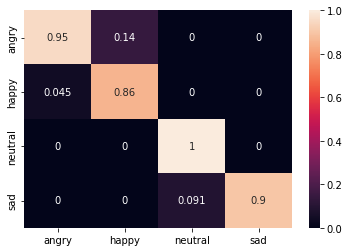

In [ ]:
ensembled_minussc.save_weights('EMO_DB//models//ensembled_minussc.h5')
print(ensembled_minussc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minussc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minussc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 131ms/step - loss: 0.1529 - accuracy: 0.9400
[0.15292352437973022, 0.9399999976158142]
F1 SCORE: 0.9291125541125542
Kappa: 0.9141385231825987
Accuracy: 0.94
Jaccard Score: 0.870306324110672
Precision: 0.9301948051948052
Recall: 0.9301948051948052


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


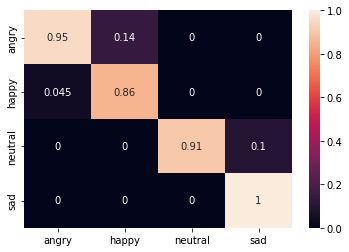

In [ ]:
ensembled_minussc.load_weights('EMO_DB//models//ensembled_minussc_loss.h5')
print(ensembled_minussc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minussc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minussc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())

2/2 [==============================] - 0s 126ms/step - loss: 0.2286 - accuracy: 0.9000
[0.22855211794376373, 0.8999999761581421]
F1 SCORE: 0.8779137529137528
Kappa: 0.8557414887478361
Accuracy: 0.9
Jaccard Score: 0.787878787878788
Precision: 0.8949275362318841
Recall: 0.8717532467532468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


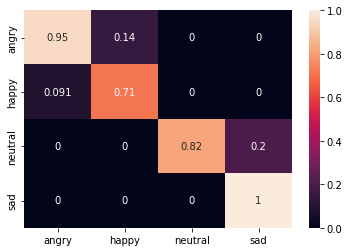

In [ ]:
ensembled_minussc.load_weights('EMO_DB//models//ensembled_minussc_acc.h5')
print(ensembled_minussc.evaluate([X_test,X_test_features],Y_test))
g = np.argmax(Y_test,axis = -1)
p = np.argmax(ensembled_minussc.predict([X_test,X_test_features]),axis = -1)
g.ravel()
p.ravel()
from sklearn.metrics import *

f1 = f1_score(g,p,average = 'macro')
kappa = cohen_kappa_score(g,p)
accuracy = accuracy_score(g,p) 
jaccard = jaccard_score(g,p,average = 'macro')
precision = precision_score(g,p,average = 'macro') 
recall = recall_score(g,p,average = 'macro')
#print(np.unique(gt),np.unique(pd))
print("F1 SCORE:", f1)
print("Kappa:",kappa)
print("Accuracy:",accuracy)
print("Jaccard Score:",jaccard)
print("Precision:",precision)
print("Recall:",recall)


cf_matrix = confusion_matrix(np.argmax(Y_test,axis = -1),np.argmax(ensembled_minussc.predict([X_test,X_test_features]),axis = -1))
sns.heatmap(cf_matrix/cf_matrix.astype(np.float).sum(axis=1), annot=True, xticklabels =label_dict.keys(),yticklabels =label_dict.keys())